# RNN - 시계열데이터

In [ ]:
!unzip /content/drive/MyDrive/data/netflix-stock-prediction.zip

Archive:  /content/drive/MyDrive/data/netflix-stock-prediction.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
import pandas as pd
import numpy as np

train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
train.head()

,Date,Open,High,Low,Volume,Close
0,2015-12-16,120,123,118,13181000,123
1,2015-12-17,124,126,122,17284900,123
2,2015-12-18,121,122,118,17948100,118
3,2015-12-21,120,120,116,11670000,117
4,2015-12-22,117,117,115,9689000,116


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    967 non-null    object
 1   Open    967 non-null    int64 
 2   High    967 non-null    int64 
 3   Low     967 non-null    int64 
 4   Volume  967 non-null    int64 
 5   Close   967 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 45.5+ KB


In [ ]:
train.describe()

,Open,High,Low,Volume,Close
count,967.000000,967.000000,967.000000,9.670000e+02,967.000000
mean,223.923475,227.154085,220.323681,9.886233e+06,223.827301
std,104.455030,106.028484,102.549658,6.467710e+06,104.319356
min,81.000000,85.000000,80.000000,1.616300e+06,83.000000
25%,124.000000,126.000000,123.000000,5.638150e+06,124.000000
50%,194.000000,196.000000,192.000000,8.063300e+06,194.000000
75%,329.000000,332.000000,323.000000,1.198440e+07,327.500000
max,421.000000,423.000000,413.000000,5.841040e+07,419.000000


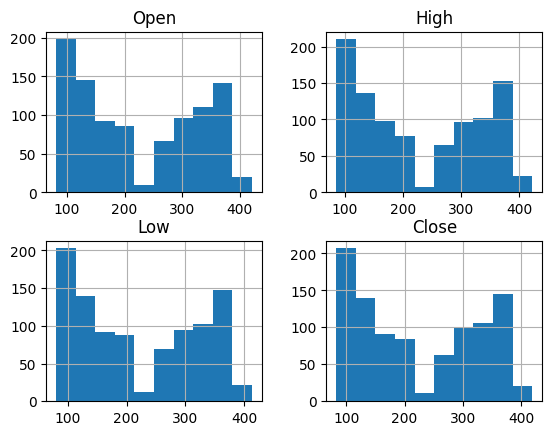

In [ ]:
# 데이터 분포 확인  Open Hight Low Close  hist
import matplotlib.pyplot as plt

sample = train.iloc[:, 1:4]
sample['Close'] = train['Close']
sample.hist()
plt.show()

In [ ]:
# String -> datatime변경
train['Date'] = pd.to_datetime(train['Date'])
train['year'] = train['Date'].dt.year
train['year'].unique()

array([2015, 2016, 2017, 2018, 2019], dtype=int32)

In [ ]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd
class NetflixDataset(Dataset):
  def __init__(self, csv_path):
    df = pd.read_csv(csv_path)
    self.data = df.iloc[:,1:4].to_numpy()
    # 0~1 사이로 정규화
    self.data = self.data/np.max(self.data)
    # 정답(종가)
    self.label = df.iloc[:,-1].to_numpy()
    self.label = self.label / np.max(self.label)
  def __len__(self):
    return len(self.data) - 30
  def __getitem__(self,idx):
    data = self.data[idx:idx+30]
    label = self.label[idx+30]
    return data, label

In [ ]:
netflix_dataset = NetflixDataset('/content/train.csv')
data,label = next(iter(netflix_dataset))
netflix_dataloader = DataLoader(netflix_dataset,batch_size=32)  # 시계열 데이터라서 shuffle 금지
data,label = next(iter(netflix_dataloader))
data.shape, label.shape

(torch.Size([32, 30, 3]), torch.Size([32]))

In [ ]:
import torch
import torch.nn as nn
class NetflixRnn(nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = nn.RNN(input_size=3, hidden_size=10, num_layers=5, batch_first=True) # 입력의 모양을 (bacth_size,Seq_len,input_size)
    # RNN 출력 (batch_size, seq_szie, hidden_size) (32,30,10)
    # 분류기
    self.linear1 = nn.Linear(in_features=30*10, out_features=100)
    self.linear2 = nn.Linear(in_features=100, out_features=1)
    self.relu = nn.ReLU()
  def forward(self,x,h0):  # h0 초기 은닉상태
    x, hn =  self.rnn(x, h0)  # x RNN을 통과한 모든 시점의 출력(batch_size, seq_len, hidden_size)
    # hn : 마지막 시점의 은닉상태들(num_layer를 포함) -> 사용안함
    # x --> (batch_size, 30,10)
    x = torch.flatten(x,start_dim=1)
    x = self.relu(self.linear1(x))
    x = self.linear2(x)
    return x

In [ ]:
# 모델 생성
netflix = NetflixRnn()
netflix

NetflixRnn(
  (rnn): RNN(3, 10, num_layers=5, batch_first=True)
  (linear1): Linear(in_features=300, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
# 학습
# 손실함수, 옵티마이저, 러닝레이트, 에포크수
from tqdm import tqdm
device = 'cuda' if torch.cuda.is_available() else 'cpu'
loss_fn = nn.MSELoss()
lr = 1e-4
epochs =200
epoch_loss = 0.0
optimizer = torch.optim.Adam(netflix.parameters(), lr=lr)
netflix = netflix.to(device)
for epoch in range(epochs):
  iterator =tqdm(netflix_dataloader)
  for data, label in iterator:
     # float -> torch.float32
    # double -> torch.float64
    # 텐서의 학습은 기본인 torch.float32
    label = label.reshape(-1,1).to(torch.float32).to(device)
    data = data.clone().detach().to(torch.float32).to(device)  # float -> 32bit
    # 초기 은닉상태 정의
    # 배치마다 은닉상태를 0으로 초기화
    h0 = torch.zeros(5,data.shape[0], 10).to(device) # num_layers, batch_size, hidden_size

    # 예측
    pred = netflix(data, h0)
    # 오차
    loss = loss_fn(pred, label)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    epoch_loss += loss.item()
    iterator.set_description(f'loss : {loss.item()}')
  print(f'epoch : {epoch + 1} loss : {epoch_loss/len(netflix_dataloader)}')


loss : 0.025792637839913368: 100%|██████████| 30/30 [00:01<00:00, 27.46it/s]


epoch : 1 loss : 0.11844645819316307


loss : 0.003499496728181839: 100%|██████████| 30/30 [00:00<00:00, 38.14it/s]


epoch : 2 loss : 0.1718309356365353


loss : 0.00600242055952549: 100%|██████████| 30/30 [00:00<00:00, 42.01it/s]


epoch : 3 loss : 0.23682930211847028


loss : 0.004505017772316933: 100%|██████████| 30/30 [00:00<00:00, 43.76it/s]


epoch : 4 loss : 0.29326964255111915


loss : 0.002800985937938094: 100%|██████████| 30/30 [00:00<00:00, 41.20it/s]


epoch : 5 loss : 0.3429675480894124


loss : 0.0011187789496034384: 100%|██████████| 30/30 [00:00<00:00, 43.85it/s]


epoch : 6 loss : 0.3825488273597633


loss : 0.0004321503802202642: 100%|██████████| 30/30 [00:00<00:00, 43.16it/s]


epoch : 7 loss : 0.4076864510444769


loss : 0.0033340868540108204: 100%|██████████| 30/30 [00:00<00:00, 42.60it/s]


epoch : 8 loss : 0.4175040002577589


loss : 0.003411994781345129: 100%|██████████| 30/30 [00:00<00:00, 42.99it/s]


epoch : 9 loss : 0.4206553314043655


loss : 0.004099431913346052: 100%|██████████| 30/30 [00:00<00:00, 43.29it/s]


epoch : 10 loss : 0.4241330913697311


loss : 0.004847681615501642: 100%|██████████| 30/30 [00:00<00:00, 43.61it/s]


epoch : 11 loss : 0.4271887632504028


loss : 0.004429797641932964: 100%|██████████| 30/30 [00:00<00:00, 43.31it/s]


epoch : 12 loss : 0.43015730951404596


loss : 0.004281105939298868: 100%|██████████| 30/30 [00:00<00:00, 43.81it/s]


epoch : 13 loss : 0.4330492853764857


loss : 0.004493647255003452: 100%|██████████| 30/30 [00:00<00:00, 42.46it/s]


epoch : 14 loss : 0.4359689583493188


loss : 0.004672729875892401: 100%|██████████| 30/30 [00:00<00:00, 43.79it/s]


epoch : 15 loss : 0.4389167070059557


loss : 0.004574907943606377: 100%|██████████| 30/30 [00:00<00:00, 32.01it/s]


epoch : 16 loss : 0.44184634635706366


loss : 0.004694550763815641: 100%|██████████| 30/30 [00:00<00:00, 30.20it/s]


epoch : 17 loss : 0.4447853243317392


loss : 0.004748101811856031: 100%|██████████| 30/30 [00:00<00:00, 30.17it/s]


epoch : 18 loss : 0.4477446333779881


loss : 0.004863184876739979: 100%|██████████| 30/30 [00:01<00:00, 28.74it/s]


epoch : 19 loss : 0.4507238332843068


loss : 0.004847629461437464: 100%|██████████| 30/30 [00:00<00:00, 34.11it/s]


epoch : 20 loss : 0.45371117374282527


loss : 0.004976989701390266: 100%|██████████| 30/30 [00:00<00:00, 42.43it/s]


epoch : 21 loss : 0.4567173525188688


loss : 0.00501837395131588: 100%|██████████| 30/30 [00:00<00:00, 41.93it/s]


epoch : 22 loss : 0.45974011087725253


loss : 0.005029215943068266: 100%|██████████| 30/30 [00:00<00:00, 42.37it/s]


epoch : 23 loss : 0.46276837844807234


loss : 0.005148887634277344: 100%|██████████| 30/30 [00:00<00:00, 41.57it/s]


epoch : 24 loss : 0.46581740617578665


loss : 0.0051545570604503155: 100%|██████████| 30/30 [00:00<00:00, 42.27it/s]


epoch : 25 loss : 0.4688774719020027


loss : 0.005222423933446407: 100%|██████████| 30/30 [00:00<00:00, 42.49it/s]


epoch : 26 loss : 0.4719439978091638


loss : 0.00521073117852211: 100%|██████████| 30/30 [00:00<00:00, 42.78it/s]


epoch : 27 loss : 0.47501621165914304


loss : 0.005311198066920042: 100%|██████████| 30/30 [00:00<00:00, 41.61it/s]


epoch : 28 loss : 0.4781005678221239


loss : 0.005332349333912134: 100%|██████████| 30/30 [00:00<00:00, 42.03it/s]


epoch : 29 loss : 0.48119386185107943


loss : 0.005307917948812246: 100%|██████████| 30/30 [00:00<00:00, 42.38it/s]


epoch : 30 loss : 0.4842815468813266


loss : 0.005398759618401527: 100%|██████████| 30/30 [00:00<00:00, 40.88it/s]


epoch : 31 loss : 0.48737938721575724


loss : 0.005412154830992222: 100%|██████████| 30/30 [00:00<00:00, 42.17it/s]


epoch : 32 loss : 0.49048379367620026


loss : 0.005382637958973646: 100%|██████████| 30/30 [00:00<00:00, 43.40it/s]


epoch : 33 loss : 0.4935802639037926


loss : 0.005457225721329451: 100%|██████████| 30/30 [00:00<00:00, 33.15it/s]


epoch : 34 loss : 0.49668315044633954


loss : 0.005468058865517378: 100%|██████████| 30/30 [00:00<00:00, 30.55it/s]


epoch : 35 loss : 0.4997902925444275


loss : 0.005434548482298851: 100%|██████████| 30/30 [00:01<00:00, 29.73it/s]


epoch : 36 loss : 0.5028884124171176


loss : 0.005496213212609291: 100%|██████████| 30/30 [00:01<00:00, 27.77it/s]


epoch : 37 loss : 0.5059905554976164


loss : 0.005506226792931557: 100%|██████████| 30/30 [00:00<00:00, 31.79it/s]


epoch : 38 loss : 0.5090953257056754


loss : 0.005464741960167885: 100%|██████████| 30/30 [00:00<00:00, 39.58it/s]


epoch : 39 loss : 0.5121896998465066


loss : 0.005516394507139921: 100%|██████████| 30/30 [00:01<00:00, 23.25it/s]


epoch : 40 loss : 0.5152856240173302


loss : 0.005523838568478823: 100%|██████████| 30/30 [00:00<00:00, 40.77it/s]


epoch : 41 loss : 0.5183833838374994


loss : 0.005485863890498877: 100%|██████████| 30/30 [00:00<00:00, 42.62it/s]


epoch : 42 loss : 0.5214710145327142


loss : 0.005523428320884705: 100%|██████████| 30/30 [00:00<00:00, 41.96it/s]


epoch : 43 loss : 0.5245582503685


loss : 0.00552035216242075: 100%|██████████| 30/30 [00:00<00:00, 41.53it/s]


epoch : 44 loss : 0.5276444473062838


loss : 0.005494897719472647: 100%|██████████| 30/30 [00:00<00:00, 42.46it/s]


epoch : 45 loss : 0.5307220342348652


loss : 0.0055197919718921185: 100%|██████████| 30/30 [00:00<00:00, 30.28it/s]


epoch : 46 loss : 0.533797930964253


loss : 0.005487600341439247: 100%|██████████| 30/30 [00:01<00:00, 22.13it/s]


epoch : 47 loss : 0.5368680897066346


loss : 0.005509636364877224: 100%|██████████| 30/30 [00:00<00:00, 41.55it/s]


epoch : 48 loss : 0.5399345641583447


loss : 0.005488317925482988: 100%|██████████| 30/30 [00:00<00:00, 42.09it/s]


epoch : 49 loss : 0.5429964583018166


loss : 0.005480374209582806: 100%|██████████| 30/30 [00:00<00:00, 31.52it/s]


epoch : 50 loss : 0.5460508120041292


loss : 0.005464551970362663: 100%|██████████| 30/30 [00:01<00:00, 28.34it/s]


epoch : 51 loss : 0.5490994826685286


loss : 0.00546508701518178: 100%|██████████| 30/30 [00:00<00:00, 31.27it/s]


epoch : 52 loss : 0.5521431903328449


loss : 0.00544555950909853: 100%|██████████| 30/30 [00:01<00:00, 29.73it/s]


epoch : 53 loss : 0.5551806592309428


loss : 0.005436493083834648: 100%|██████████| 30/30 [00:00<00:00, 32.68it/s]


epoch : 54 loss : 0.558211514506335


loss : 0.005418781191110611: 100%|██████████| 30/30 [00:00<00:00, 40.68it/s]


epoch : 55 loss : 0.5612355983141545


loss : 0.005404791794717312: 100%|██████████| 30/30 [00:00<00:00, 32.67it/s]


epoch : 56 loss : 0.5642525346763553


loss : 0.005386074539273977: 100%|██████████| 30/30 [00:00<00:00, 40.83it/s]


epoch : 57 loss : 0.5672620479047813


loss : 0.005365442950278521: 100%|██████████| 30/30 [00:00<00:00, 41.68it/s]


epoch : 58 loss : 0.5702634043856657


loss : 0.005348029546439648: 100%|██████████| 30/30 [00:00<00:00, 42.90it/s]


epoch : 59 loss : 0.5732570974710446


loss : 0.0053248279727995396: 100%|██████████| 30/30 [00:00<00:00, 40.87it/s]


epoch : 60 loss : 0.57624237271469


loss : 0.005304069723933935: 100%|██████████| 30/30 [00:00<00:00, 38.87it/s]


epoch : 61 loss : 0.5792190868791598


loss : 0.0051852199248969555: 100%|██████████| 30/30 [00:00<00:00, 41.46it/s]


epoch : 62 loss : 0.5821737678923758


loss : 0.005406095180660486: 100%|██████████| 30/30 [00:00<00:00, 41.65it/s]


epoch : 63 loss : 0.5851558812407347


loss : 0.0054915533401072025: 100%|██████████| 30/30 [00:00<00:00, 41.96it/s]


epoch : 64 loss : 0.5881957795896293


loss : 0.00544954277575016: 100%|██████████| 30/30 [00:00<00:00, 41.78it/s]


epoch : 65 loss : 0.5912162551178881


loss : 0.0053470865823328495: 100%|██████████| 30/30 [00:00<00:00, 42.06it/s]


epoch : 66 loss : 0.5942031258177849


loss : 0.0052390797063708305: 100%|██████████| 30/30 [00:00<00:00, 37.91it/s]


epoch : 67 loss : 0.5971496652584695


loss : 0.005136249121278524: 100%|██████████| 30/30 [00:01<00:00, 29.37it/s]


epoch : 68 loss : 0.6000607585702407


loss : 0.005052621942013502: 100%|██████████| 30/30 [00:00<00:00, 30.02it/s]


epoch : 69 loss : 0.6029433378074222


loss : 0.0049852486699819565: 100%|██████████| 30/30 [00:01<00:00, 29.92it/s]


epoch : 70 loss : 0.6058045546603049


loss : 0.004944418091326952: 100%|██████████| 30/30 [00:01<00:00, 29.54it/s]


epoch : 71 loss : 0.6086522583895809


loss : 0.004906394053250551: 100%|██████████| 30/30 [00:00<00:00, 36.28it/s]


epoch : 72 loss : 0.6114900238724051


loss : 0.004892661701887846: 100%|██████████| 30/30 [00:00<00:00, 41.42it/s]


epoch : 73 loss : 0.6143232280269634


loss : 0.004878556821495295: 100%|██████████| 30/30 [00:01<00:00, 20.95it/s]


epoch : 74 loss : 0.6171519450509246


loss : 0.004839054308831692: 100%|██████████| 30/30 [00:01<00:00, 17.95it/s]


epoch : 75 loss : 0.6199737057829224


loss : 0.004839063622057438: 100%|██████████| 30/30 [00:00<00:00, 41.04it/s]


epoch : 76 loss : 0.6227922600944719


loss : 0.004806308075785637: 100%|██████████| 30/30 [00:00<00:00, 35.41it/s]


epoch : 77 loss : 0.6256013714935459


loss : 0.004779646173119545: 100%|██████████| 30/30 [00:00<00:00, 34.47it/s]


epoch : 78 loss : 0.6284009920591719


loss : 0.004716276656836271: 100%|██████████| 30/30 [00:00<00:00, 31.24it/s]


epoch : 79 loss : 0.6311847114943703


loss : 0.004682891070842743: 100%|██████████| 30/30 [00:00<00:00, 33.43it/s]


epoch : 80 loss : 0.6339553826637409


loss : 0.0046388269402086735: 100%|██████████| 30/30 [00:01<00:00, 29.47it/s]


epoch : 81 loss : 0.6367098967620829


loss : 0.004582077264785767: 100%|██████████| 30/30 [00:01<00:00, 26.13it/s]


epoch : 82 loss : 0.6394479350735309


loss : 0.004519037902355194: 100%|██████████| 30/30 [00:01<00:00, 26.37it/s]


epoch : 83 loss : 0.6421680061126305


loss : 0.004478418733924627: 100%|██████████| 30/30 [00:01<00:00, 24.27it/s]


epoch : 84 loss : 0.6448736044780465


loss : 0.0044295694679021835: 100%|██████████| 30/30 [00:01<00:00, 22.00it/s]


epoch : 85 loss : 0.6475631781565425


loss : 0.004375477787107229: 100%|██████████| 30/30 [00:00<00:00, 35.28it/s]


epoch : 86 loss : 0.6502374599957572


loss : 0.004330129828304052: 100%|██████████| 30/30 [00:00<00:00, 38.87it/s]


epoch : 87 loss : 0.6528979894184582


loss : 0.0042826225981116295: 100%|██████████| 30/30 [00:00<00:00, 33.27it/s]


epoch : 88 loss : 0.6555438158208441


loss : 0.004226842895150185: 100%|██████████| 30/30 [00:00<00:00, 40.39it/s]


epoch : 89 loss : 0.6581748938747599


loss : 0.004193018190562725: 100%|██████████| 30/30 [00:00<00:00, 36.93it/s]


epoch : 90 loss : 0.6607937613180184


loss : 0.004138309042900801: 100%|██████████| 30/30 [00:00<00:00, 32.63it/s]


epoch : 91 loss : 0.6633974779974475


loss : 0.004094840493053198: 100%|██████████| 30/30 [00:00<00:00, 40.41it/s]


epoch : 92 loss : 0.6659879536115113


loss : 0.004043556749820709: 100%|██████████| 30/30 [00:00<00:00, 43.08it/s]


epoch : 93 loss : 0.6685630527793062


loss : 0.003990737721323967: 100%|██████████| 30/30 [00:00<00:00, 39.78it/s]


epoch : 94 loss : 0.6711227539892813


loss : 0.003938070964068174: 100%|██████████| 30/30 [00:01<00:00, 25.36it/s]


epoch : 95 loss : 0.6736664576665741


loss : 0.00388239580206573: 100%|██████████| 30/30 [00:00<00:00, 39.17it/s]


epoch : 96 loss : 0.6761934767155859


loss : 0.0038277385756373405: 100%|██████████| 30/30 [00:01<00:00, 29.16it/s]


epoch : 97 loss : 0.6787040271366398


loss : 0.0037714135833084583: 100%|██████████| 30/30 [00:01<00:00, 23.58it/s]


epoch : 98 loss : 0.6811978154435565


loss : 0.003717341460287571: 100%|██████████| 30/30 [00:01<00:00, 22.53it/s]


epoch : 99 loss : 0.6836750114212615


loss : 0.003657344728708267: 100%|██████████| 30/30 [00:01<00:00, 19.08it/s]


epoch : 100 loss : 0.6861351235657518


loss : 0.0036006374284625053: 100%|██████████| 30/30 [00:01<00:00, 16.96it/s]


epoch : 101 loss : 0.6885783816352462


loss : 0.0035472537856549025: 100%|██████████| 30/30 [00:00<00:00, 32.88it/s]


epoch : 102 loss : 0.6910063226998925


loss : 0.003497119527310133: 100%|██████████| 30/30 [00:00<00:00, 41.22it/s]


epoch : 103 loss : 0.6934181616271113


loss : 0.0034383314196020365: 100%|██████████| 30/30 [00:00<00:00, 37.80it/s]


epoch : 104 loss : 0.6958146394145539


loss : 0.0033895904198288918: 100%|██████████| 30/30 [00:00<00:00, 41.24it/s]


epoch : 105 loss : 0.6981957631830179


loss : 0.0033261962234973907: 100%|██████████| 30/30 [00:00<00:00, 40.94it/s]


epoch : 106 loss : 0.7005602383453758


loss : 0.0032770931720733643: 100%|██████████| 30/30 [00:00<00:00, 41.14it/s]


epoch : 107 loss : 0.7029095581837889


loss : 0.0032296953722834587: 100%|██████████| 30/30 [00:00<00:00, 40.87it/s]


epoch : 108 loss : 0.7052435231383546


loss : 0.0031595241744071245: 100%|██████████| 30/30 [00:00<00:00, 41.60it/s]


epoch : 109 loss : 0.7075597339276404


loss : 0.0031089037656784058: 100%|██████████| 30/30 [00:00<00:00, 41.38it/s]


epoch : 110 loss : 0.7098596856690468


loss : 0.003050296800211072: 100%|██████████| 30/30 [00:00<00:00, 40.38it/s]


epoch : 111 loss : 0.7121434902894787


loss : 0.002998574636876583: 100%|██████████| 30/30 [00:00<00:00, 40.34it/s]


epoch : 112 loss : 0.7144120831302038


loss : 0.002942835446447134: 100%|██████████| 30/30 [00:00<00:00, 36.79it/s]


epoch : 113 loss : 0.7166647699771905


loss : 0.002886545844376087: 100%|██████████| 30/30 [00:00<00:00, 30.99it/s]


epoch : 114 loss : 0.7189014372678079


loss : 0.0028290017507970333: 100%|██████████| 30/30 [00:01<00:00, 28.92it/s]


epoch : 115 loss : 0.7211215407930467


loss : 0.002770664170384407: 100%|██████████| 30/30 [00:00<00:00, 30.41it/s]


epoch : 116 loss : 0.7233252918158238


loss : 0.0027163689956068993: 100%|██████████| 30/30 [00:01<00:00, 27.50it/s]


epoch : 117 loss : 0.7255130624198197


loss : 0.002664657775312662: 100%|██████████| 30/30 [00:00<00:00, 39.76it/s]


epoch : 118 loss : 0.7276864827266157


loss : 0.0026138985995203257: 100%|██████████| 30/30 [00:00<00:00, 39.30it/s]


epoch : 119 loss : 0.7298458096674343


loss : 0.0025649776216596365: 100%|██████████| 30/30 [00:00<00:00, 40.03it/s]


epoch : 120 loss : 0.7319919175412906


loss : 0.002639775862917304: 100%|██████████| 30/30 [00:00<00:00, 40.53it/s]


epoch : 121 loss : 0.7341995674784811


loss : 0.0032615310046821833: 100%|██████████| 30/30 [00:00<00:00, 41.68it/s]


epoch : 122 loss : 0.7366052938795898


loss : 0.003924138378351927: 100%|██████████| 30/30 [00:00<00:00, 41.31it/s]


epoch : 123 loss : 0.7394783846203002


loss : 0.004666655324399471: 100%|██████████| 30/30 [00:00<00:00, 42.66it/s]


epoch : 124 loss : 0.7427092558472396


loss : 0.004844173323363066: 100%|██████████| 30/30 [00:00<00:00, 41.54it/s]


epoch : 125 loss : 0.7460554486211852


loss : 0.004358010366559029: 100%|██████████| 30/30 [00:00<00:00, 41.03it/s]


epoch : 126 loss : 0.7490961147354331


loss : 0.0034451603423804045: 100%|██████████| 30/30 [00:00<00:00, 41.49it/s]


epoch : 127 loss : 0.7516164990150174


loss : 0.0024841430131345987: 100%|██████████| 30/30 [00:00<00:00, 40.74it/s]


epoch : 128 loss : 0.753701699738455


loss : 0.001683485577814281: 100%|██████████| 30/30 [00:00<00:00, 40.70it/s]


epoch : 129 loss : 0.7555576445628504


loss : 0.0011370755964890122: 100%|██████████| 30/30 [00:00<00:00, 41.37it/s]


epoch : 130 loss : 0.7573262568756339


loss : 0.0008292978163808584: 100%|██████████| 30/30 [00:00<00:00, 35.06it/s]


epoch : 131 loss : 0.7590446487330155


loss : 0.000726379337720573: 100%|██████████| 30/30 [00:00<00:00, 31.63it/s]


epoch : 132 loss : 0.7607195937852339


loss : 0.0005113244988024235: 100%|██████████| 30/30 [00:00<00:00, 30.43it/s]


epoch : 133 loss : 0.7623104533053568


loss : 0.0006000414141453803: 100%|██████████| 30/30 [00:00<00:00, 32.36it/s]


epoch : 134 loss : 0.7638944509847534


loss : 0.0011912899790331721: 100%|██████████| 30/30 [00:01<00:00, 28.54it/s]


epoch : 135 loss : 0.7659215737416465


loss : 0.0026636638212949038: 100%|██████████| 30/30 [00:00<00:00, 34.09it/s]


epoch : 136 loss : 0.7688318778247473


loss : 0.003979608882218599: 100%|██████████| 30/30 [00:00<00:00, 42.43it/s]


epoch : 137 loss : 0.7724918303352448


loss : 0.005028071813285351: 100%|██████████| 30/30 [00:00<00:00, 39.88it/s]


epoch : 138 loss : 0.7766847034131388


loss : 0.004476482048630714: 100%|██████████| 30/30 [00:00<00:00, 41.17it/s]


epoch : 139 loss : 0.7804939720450723


loss : 0.003409787779673934: 100%|██████████| 30/30 [00:00<00:00, 41.48it/s]


epoch : 140 loss : 0.7833687610716576


loss : 0.0020278862211853266: 100%|██████████| 30/30 [00:00<00:00, 42.15it/s]


epoch : 141 loss : 0.7854319592317854


loss : 0.0010933405719697475: 100%|██████████| 30/30 [00:00<00:00, 40.49it/s]


epoch : 142 loss : 0.7871710964406702


loss : 0.0005824391846545041: 100%|██████████| 30/30 [00:00<00:00, 41.13it/s]


epoch : 143 loss : 0.7888848196803337


loss : 0.00040835762047208846: 100%|██████████| 30/30 [00:00<00:00, 41.89it/s]


epoch : 144 loss : 0.7905988958674849


loss : 0.00038218352710828185: 100%|██████████| 30/30 [00:01<00:00, 25.11it/s]


epoch : 145 loss : 0.7922016847113204


loss : 0.00038000536733306944: 100%|██████████| 30/30 [00:00<00:00, 40.90it/s]


epoch : 146 loss : 0.793681937111099


loss : 0.00043130473932251334: 100%|██████████| 30/30 [00:00<00:00, 40.49it/s]


epoch : 147 loss : 0.7951666644751944


loss : 0.0007117111817933619: 100%|██████████| 30/30 [00:00<00:00, 40.83it/s]


epoch : 148 loss : 0.7969029101273312


loss : 0.0013301405124366283: 100%|██████████| 30/30 [00:00<00:00, 32.94it/s]


epoch : 149 loss : 0.7991046099978727


loss : 0.002088814275339246: 100%|██████████| 30/30 [00:00<00:00, 30.65it/s]


epoch : 150 loss : 0.801705912692402


loss : 0.002422098070383072: 100%|██████████| 30/30 [00:00<00:00, 30.08it/s]


epoch : 151 loss : 0.8043565342941899


loss : 0.0022406752686947584: 100%|██████████| 30/30 [00:01<00:00, 29.36it/s]


epoch : 152 loss : 0.8068076755702956


loss : 0.0018250513821840286: 100%|██████████| 30/30 [00:01<00:00, 28.65it/s]


epoch : 153 loss : 0.8089501504414632


loss : 0.0013356675626710057: 100%|██████████| 30/30 [00:00<00:00, 36.84it/s]


epoch : 154 loss : 0.8107903921945763


loss : 0.0009089327650144696: 100%|██████████| 30/30 [00:00<00:00, 36.45it/s]


epoch : 155 loss : 0.8124258643156888


loss : 0.0006043786997906864: 100%|██████████| 30/30 [00:00<00:00, 39.45it/s]


epoch : 156 loss : 0.8139588197226355


loss : 0.00043545186053961515: 100%|██████████| 30/30 [00:00<00:00, 38.52it/s]


epoch : 157 loss : 0.8154474715367541


loss : 0.00037690732278861105: 100%|██████████| 30/30 [00:00<00:00, 38.49it/s]


epoch : 158 loss : 0.8169053108954055


loss : 0.00037133542355149984: 100%|██████████| 30/30 [00:00<00:00, 40.70it/s]


epoch : 159 loss : 0.8183245417670454


loss : 0.0003662553208414465: 100%|██████████| 30/30 [00:00<00:00, 40.80it/s]


epoch : 160 loss : 0.819712079012


loss : 0.0003632772422861308: 100%|██████████| 30/30 [00:00<00:00, 41.31it/s]


epoch : 161 loss : 0.8211065593984433


loss : 0.00041085859993472695: 100%|██████████| 30/30 [00:00<00:00, 40.56it/s]


epoch : 162 loss : 0.8225665202937914


loss : 0.0005574346287176013: 100%|██████████| 30/30 [00:00<00:00, 41.06it/s]


epoch : 163 loss : 0.8241491292900416


loss : 0.0008077942184172571: 100%|██████████| 30/30 [00:00<00:00, 41.25it/s]


epoch : 164 loss : 0.8259017287880852


loss : 0.001148066483438015: 100%|██████████| 30/30 [00:00<00:00, 40.29it/s]


epoch : 165 loss : 0.8279121508759999


loss : 0.001634095679037273: 100%|██████████| 30/30 [00:00<00:00, 41.09it/s]


epoch : 166 loss : 0.8303240229755223


loss : 0.0023002917878329754: 100%|██████████| 30/30 [00:00<00:00, 32.88it/s]


epoch : 167 loss : 0.8332325919003779


loss : 0.0029442207887768745: 100%|██████████| 30/30 [00:01<00:00, 20.59it/s]


epoch : 168 loss : 0.836583158138698


loss : 0.003229925874620676: 100%|██████████| 30/30 [00:01<00:00, 29.75it/s]


epoch : 169 loss : 0.8400360943716805


loss : 0.0028463928028941154: 100%|██████████| 30/30 [00:00<00:00, 30.72it/s]


epoch : 170 loss : 0.8430690972169638


loss : 0.0019675185903906822: 100%|██████████| 30/30 [00:00<00:00, 30.05it/s]


epoch : 171 loss : 0.8453878276972925


loss : 0.0010930693242698908: 100%|██████████| 30/30 [00:00<00:00, 40.32it/s]


epoch : 172 loss : 0.8471568317287165


loss : 0.000530269811861217: 100%|██████████| 30/30 [00:00<00:00, 40.87it/s]


epoch : 173 loss : 0.8487412374106498


loss : 0.0003590354463085532: 100%|██████████| 30/30 [00:00<00:00, 40.68it/s]


epoch : 174 loss : 0.8503587298836162


loss : 0.0005114565137773752: 100%|██████████| 30/30 [00:00<00:00, 39.36it/s]


epoch : 175 loss : 0.8519919356194199


loss : 0.0007231153431348503: 100%|██████████| 30/30 [00:00<00:00, 40.40it/s]


epoch : 176 loss : 0.8535280855582338


loss : 0.000719329109415412: 100%|██████████| 30/30 [00:00<00:00, 40.43it/s]


epoch : 177 loss : 0.8549461798193079


loss : 0.000507060787640512: 100%|██████████| 30/30 [00:01<00:00, 24.07it/s]


epoch : 178 loss : 0.8563289388582537


loss : 0.00034134939778596163: 100%|██████████| 30/30 [00:00<00:00, 40.81it/s]


epoch : 179 loss : 0.8578350730250046


loss : 0.00044425189844332635: 100%|██████████| 30/30 [00:00<00:00, 41.07it/s]


epoch : 180 loss : 0.8595640860687126


loss : 0.0007109650177881122: 100%|██████████| 30/30 [00:00<00:00, 36.41it/s]


epoch : 181 loss : 0.8614578515766577


loss : 0.0009226245456375182: 100%|██████████| 30/30 [00:00<00:00, 39.92it/s]


epoch : 182 loss : 0.8633933125830178


loss : 0.0010099326027557254: 100%|██████████| 30/30 [00:00<00:00, 39.78it/s]


epoch : 183 loss : 0.8653552757420887


loss : 0.0010128107387572527: 100%|██████████| 30/30 [00:00<00:00, 31.21it/s]


epoch : 184 loss : 0.8672937484259212


loss : 0.0009366723243147135: 100%|██████████| 30/30 [00:02<00:00, 11.15it/s]


epoch : 185 loss : 0.8691477808836984


loss : 0.0008028704905882478: 100%|██████████| 30/30 [00:01<00:00, 22.66it/s]


epoch : 186 loss : 0.8708800653103632


loss : 0.0006418905686587095: 100%|██████████| 30/30 [00:01<00:00, 24.87it/s]


epoch : 187 loss : 0.8724795333375975


loss : 0.0004908791743218899: 100%|██████████| 30/30 [00:01<00:00, 21.16it/s]


epoch : 188 loss : 0.8739656776378676


loss : 0.0003831701760645956: 100%|██████████| 30/30 [00:01<00:00, 23.22it/s]


epoch : 189 loss : 0.875372895643856


loss : 0.00033789448207244277: 100%|██████████| 30/30 [00:00<00:00, 38.67it/s]


epoch : 190 loss : 0.8767324951601949


loss : 0.00035259933792985976: 100%|██████████| 30/30 [00:00<00:00, 38.98it/s]


epoch : 191 loss : 0.878063474744431


loss : 0.0004063618544023484: 100%|██████████| 30/30 [00:00<00:00, 38.35it/s]


epoch : 192 loss : 0.8793757264551763


loss : 0.0004658450197894126: 100%|██████████| 30/30 [00:01<00:00, 25.77it/s]


epoch : 193 loss : 0.8806712148844781


loss : 0.000500198919326067: 100%|██████████| 30/30 [00:00<00:00, 37.36it/s]


epoch : 194 loss : 0.881950951976099


loss : 0.0004922185908071697: 100%|██████████| 30/30 [00:01<00:00, 25.45it/s]


epoch : 195 loss : 0.8832168831408429


loss : 0.0004497554327826947: 100%|██████████| 30/30 [00:00<00:00, 38.59it/s]


epoch : 196 loss : 0.8844754575118411


loss : 0.00039330252911895514: 100%|██████████| 30/30 [00:01<00:00, 20.92it/s]


epoch : 197 loss : 0.8857371089555273


loss : 0.00034425550256855786: 100%|██████████| 30/30 [00:02<00:00, 13.04it/s]


epoch : 198 loss : 0.8870188255117379


loss : 0.00032825503149069846: 100%|██████████| 30/30 [00:01<00:00, 20.14it/s]


epoch : 199 loss : 0.8883568338762112


loss : 0.0003688106662593782: 100%|██████████| 30/30 [00:00<00:00, 34.46it/s]

epoch : 200 loss : 0.8898194911108476


In [ ]:
# 저장
torch.save(netflix.state_dict(), "netflix.pth")

In [ ]:
# 모델 로드
loaded_model = NetflixRnn()
loaded_model.load_state_dict(torch.load('netflix.pth', map_location=device))
loaded_model.eval()
pred_lists = []
total_loss = 0.0
loader = DataLoader(netflix_dataset,batch_size=1)
with torch.no_grad():
  for data ,label in netflix_dataloader:
    label = label.reshape(-1,1).to(torch.float32).to(device)
    data = data.clone().detach().to(torch.float32).to(device)
    # 예측값출력
    h0 = torch.zeros(5,data.shape[0],10).to(device)
    predict = loaded_model(data,h0)
    pred_lists.extend([p.item() for p in predict])
    loss = loss_fn(predict,label)
    total_loss += loss.item()
print(f"loss : {total_loss / len(loader.dataset)}")

loss : 6.757522910200218e-05


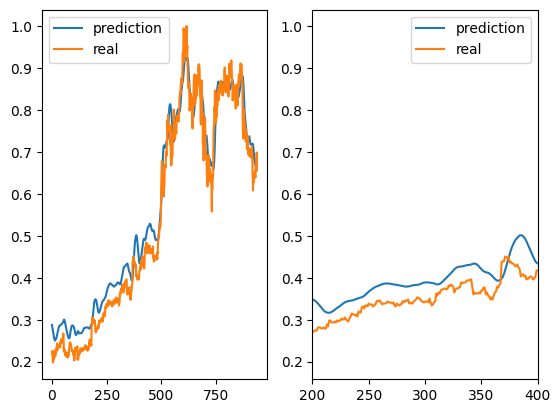

In [ ]:
import matplotlib.pyplot as plt
plt.subplot(1,2,1)
plt.plot(pred_lists, label='prediction')
plt.plot(netflix_dataset.label[30:], label='real')
plt.legend()

plt.subplot(1,2,2)
plt.plot(pred_lists, label='prediction')
plt.plot(netflix_dataset.label[30:], label='real')
plt.xlim(200,400)
plt.legend()
plt.show()

마지막 데이터 날짜 이후 데이터 예측

In [ ]:
lastdata = netflix_dataset.data[-30:]
print(lastdata.shape)
with torch.no_grad():
  h0 = torch.zeros(5,1,10).to(device)  # 레이어 배치 히든
  lastdata = lastdata.reshape(1,30,3)
  lastdata = torch.tensor(lastdata).to(torch.float32).to(device)
  print(h0.shape, lastdata.shape)
  predict = loaded_model(lastdata,h0)
  print(predict[0][0].item())

(30, 3)
torch.Size([5, 1, 10]) torch.Size([1, 30, 3])
0.6869183778762817


In [ ]:
df = pd.read_csv('/content/train.csv')
maxlabel = np.max(df.iloc[:,-1].to_numpy())
maxlabel

np.int64(419)

In [ ]:
# 2019-10-18일 다음 장에서의 종가 예측
round(predict[0][0].item()*maxlabel)

288

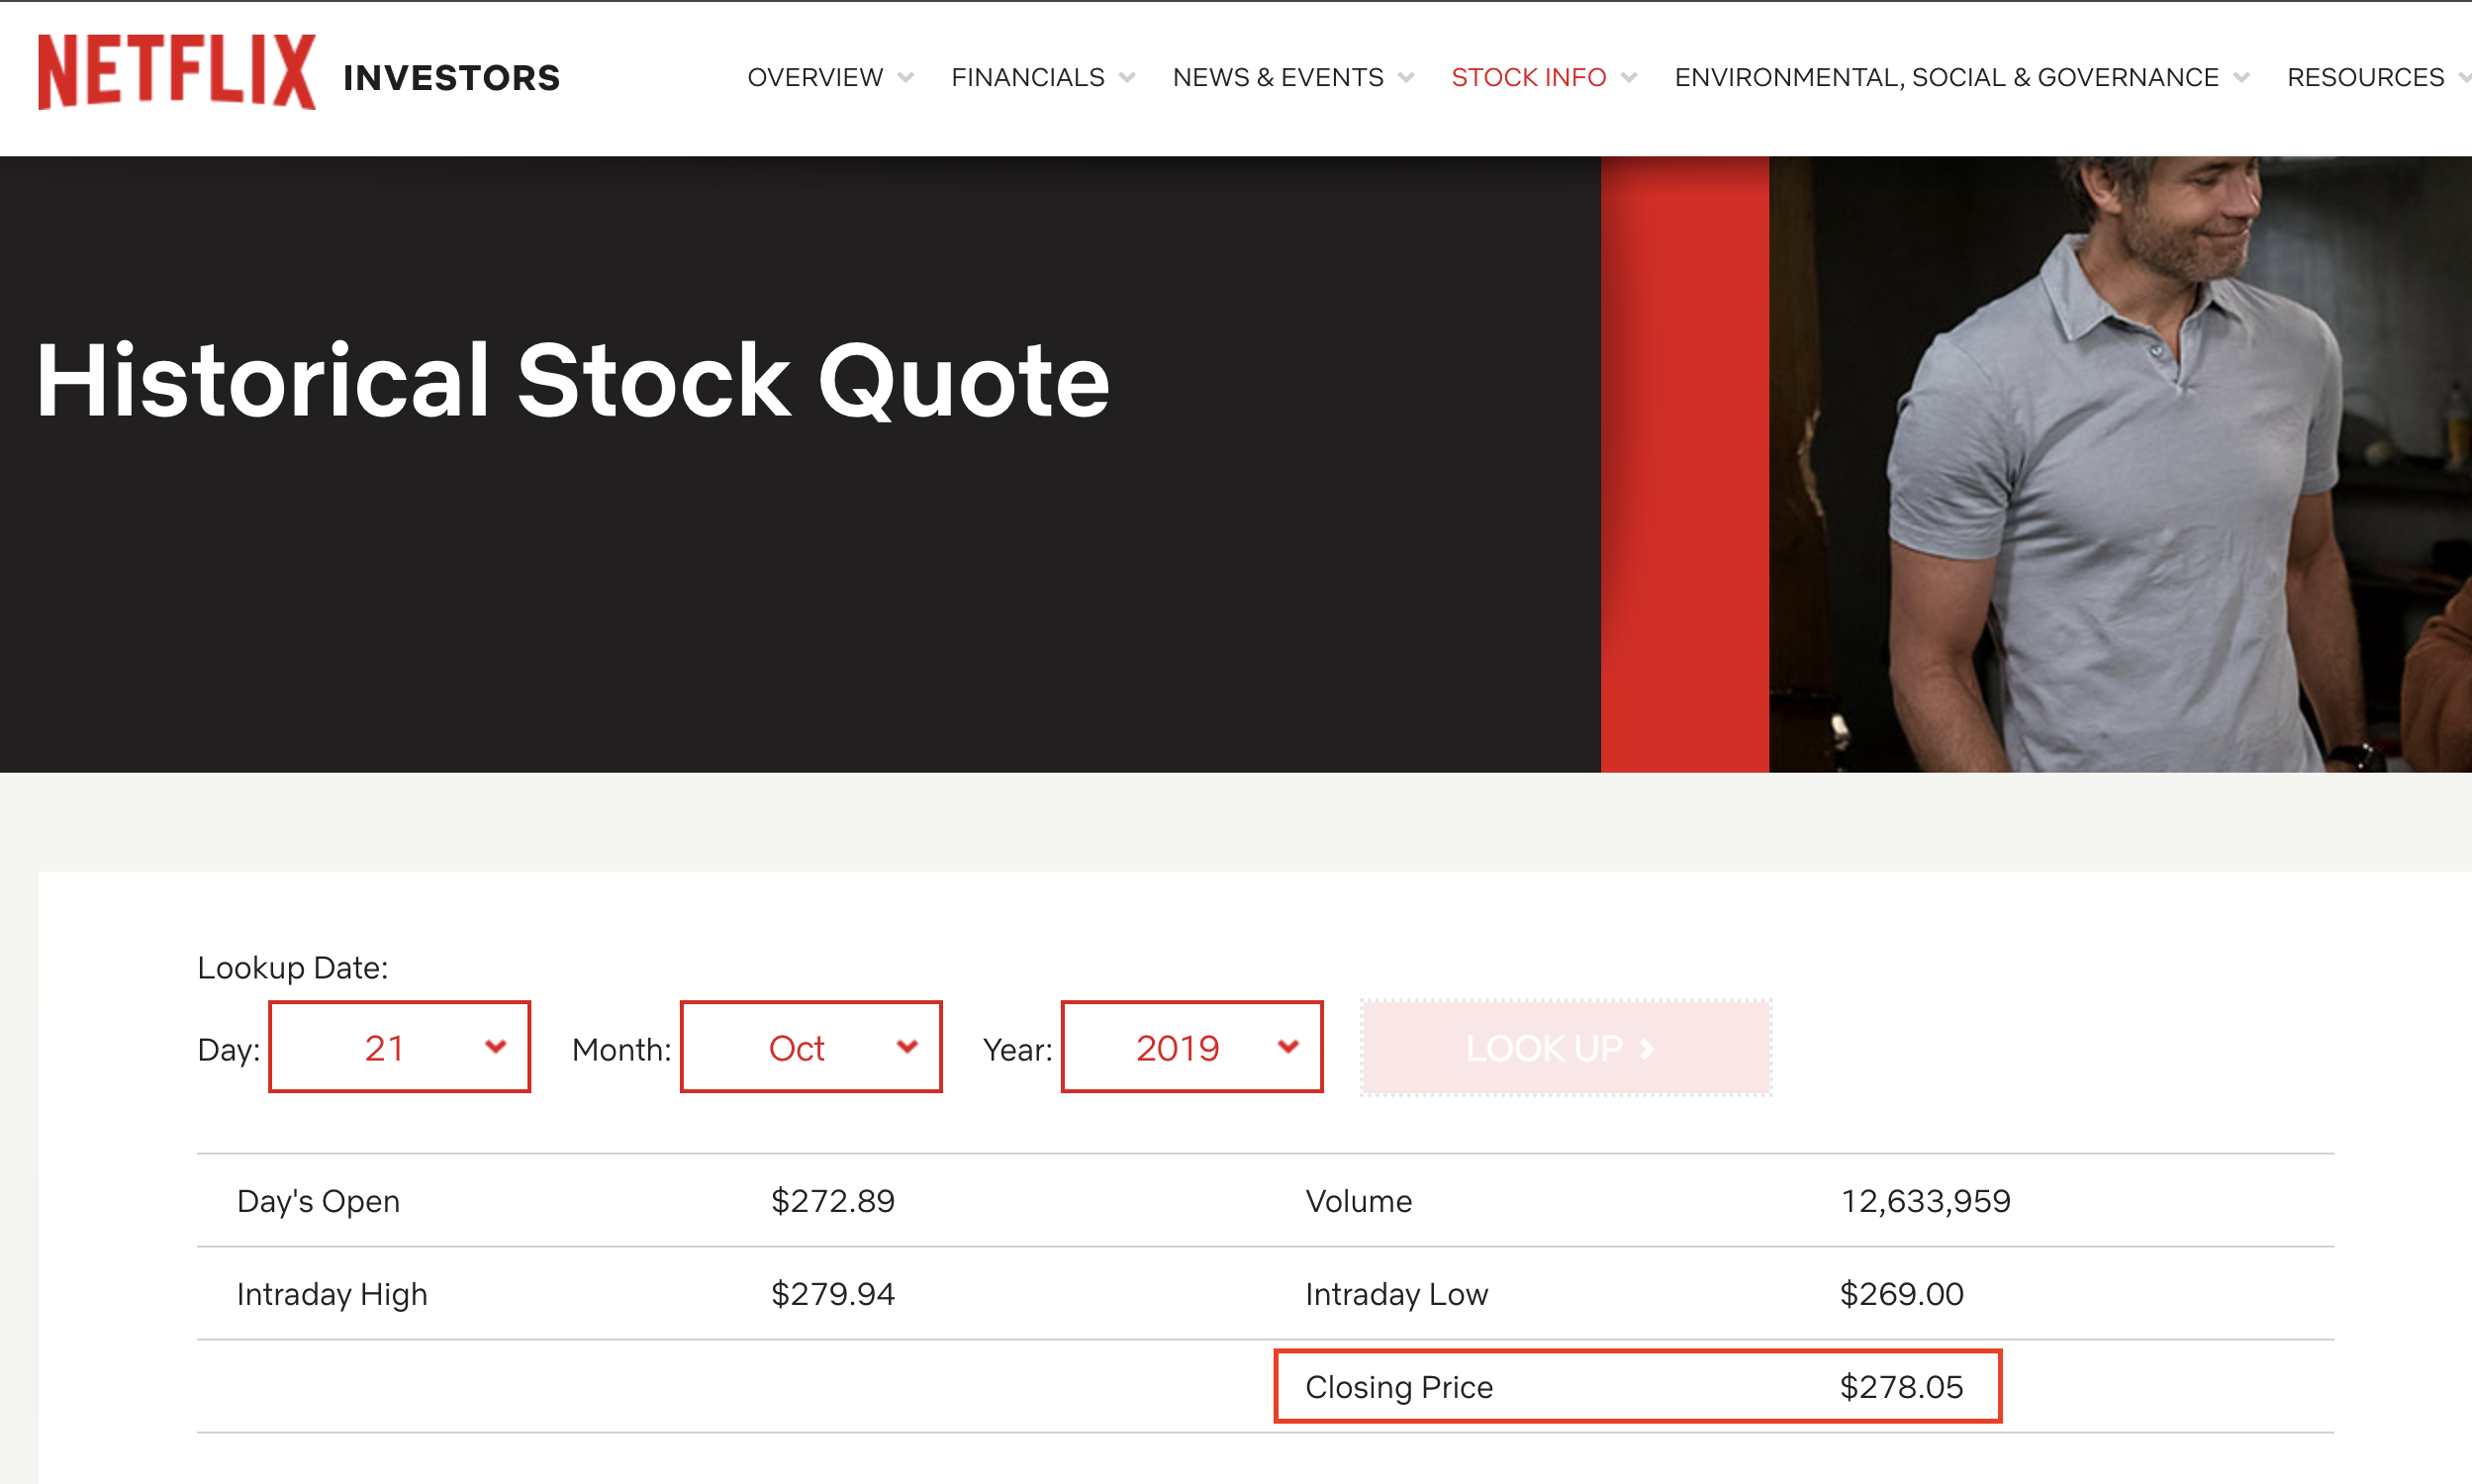

로또 번호 예측
```
RNN - LSTM - GRU
데이터셋의 sequence_len(window_size)
```

In [ ]:
import pandas as pd
import numpy as np
lott_df = pd.read_excel('/content/drive/MyDrive/data/lotto.xlsx')
(lott_df.iloc[2:,13:-1].astype(np.float32).to_numpy() - 1) / 44.0  # -1은 0부터시작하도록  44 나누는(1~45)

array([[0.29545453, 0.5       , 0.54545456, 0.59090906, 0.6363636 ,
        0.9318182 ],
       [0.11363637, 0.13636364, 0.59090906, 0.6363636 , 0.84090906,
        1.        ],
       [0.36363637, 0.38636363, 0.5       , 0.54545456, 0.84090906,
        0.8636364 ],
       ...,
       [0.02272727, 0.4090909 , 0.54545456, 0.5681818 , 0.59090906,
        0.95454544],
       [0.27272728, 0.29545453, 0.47727272, 0.59090906, 0.65909094,
        0.84090906],
       [0.02272727, 0.3409091 , 0.4090909 , 0.6818182 , 0.75      ,
        0.77272725]], dtype=float32)

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
class LottoDataSet(Dataset):
  def __init__(self,csv_path, sequence_len = 10 ):
    lott_df = pd.read_excel(csv_path).iloc[::-1] # 최신데이터가 앞에 나와서 시간순으로 다시 뒤집기
    self.data = (lott_df.iloc[:-2,13:-1].astype(np.float32).to_numpy() - 1) / 44.0
    self.sequence_len = sequence_len
  def __len__(self):
    return len(self.data) - self.sequence_len
  def __getitem__(self, index):
    data = self.data[index:index+self.sequence_len]
    label = self.data[index+self.sequence_len]
    return torch.FloatTensor(data), torch.FloatTensor(label)

sample = LottoDataSet('/content/drive/MyDrive/data/lotto.xlsx')
data,label = next(iter(sample))
data.shape, label.shape

(torch.Size([10, 6]), torch.Size([6]))

In [ ]:
class LottoRnn(nn.Module):
  def __init__(self,input_size=6, hidden_size=64,num_layers=3):
    super().__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    # RNN
    self.rnn = nn.RNN(input_size=input_size,hidden_size=hidden_size
                      ,num_layers=num_layers,batch_first=True,dropout=0.2)
    # 분류기
    self.fc = nn.Sequential(
        nn.Linear(in_features=hidden_size,out_features=128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(in_features=128,out_features=64),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(in_features=64,out_features=6),
    )
  def forward(self,x):
    # 초기 은닉상태
    h0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(device)
    out, _ = self.rnn(x,h0)  # 출력(batch_size, sequence_len, hidden_size)  (30, 10, 64)
    # 각 배치마다 10개의 시점있고. 각 시점마다 64개의 은닉상태가 있다
    # 마지막 시점의 출력  (30,64)   과거의 정보가 점점쌓여서 마지막에는 거의 모든 정보를 가지고 있다고
    out = out[:,-1,:]  # (30,64)  (sequence_len, hidden_size)
    out = self.fc(out)
    return out

In [ ]:
#  학습
lotto_dataset = LottoDataSet('/content/drive/MyDrive/data/lotto.xlsx')
lotto_dataloader = DataLoader(lotto_dataset,batch_size=32)
lotto_model = LottoRnn()
loss_fn = nn.MSELoss()
lr = 1e-4
epochs = 200
optim = torch.optim.Adam(lotto_model.parameters(), lr=lr)
lotto_model = lotto_model.to(device)
epoch_loss_list = []
for epoch in range(epochs):
  iterator = tqdm(lotto_dataloader)
  epoch_loss = 0.0
  for data, label in iterator:
    data,label = data.to(device), label.to(device)
    pred = lotto_model(data)
    loss = loss_fn(pred,label)
    loss.backward()
    optim.step()
    optim.zero_grad()
    epoch_loss += loss.item()
    iterator.set_description(f'loss : {loss.item() / len(lotto_dataloader)}')
  epoch_loss_list.append(epoch_loss / len(lotto_dataloader) )
  print(f"epoch : {epoch+1} loss : {epoch_loss / len(lotto_dataloader.dataset)}")

loss : 0.018309757113456726: 100%|██████████| 18/18 [00:00<00:00, 39.52it/s]


epoch : 1 loss : 0.01047955281871686


loss : 0.013180672294563718: 100%|██████████| 18/18 [00:00<00:00, 64.68it/s]


epoch : 2 loss : 0.008189493401659479


loss : 0.007010374632146623: 100%|██████████| 18/18 [00:00<00:00, 75.90it/s]


epoch : 3 loss : 0.005301587685621042


loss : 0.004451041006379657: 100%|██████████| 18/18 [00:00<00:00, 74.77it/s]


epoch : 4 loss : 0.0029284856248673777


loss : 0.002944600044025315: 100%|██████████| 18/18 [00:00<00:00, 77.13it/s]


epoch : 5 loss : 0.0020064451872444837


loss : 0.0029597717026869455: 100%|██████████| 18/18 [00:00<00:00, 73.16it/s]


epoch : 6 loss : 0.0016325816525508173


loss : 0.0024134044845898948: 100%|██████████| 18/18 [00:00<00:00, 73.35it/s]


epoch : 7 loss : 0.0014433764095465056


loss : 0.0025249787916739783: 100%|██████████| 18/18 [00:00<00:00, 79.26it/s]


epoch : 8 loss : 0.001510406944820349


loss : 0.0022976224621136985: 100%|██████████| 18/18 [00:00<00:00, 79.16it/s]


epoch : 9 loss : 0.001436431309302076


loss : 0.002258039183086819: 100%|██████████| 18/18 [00:00<00:00, 73.55it/s]


epoch : 10 loss : 0.001365708914190102


loss : 0.0029115714132785797: 100%|██████████| 18/18 [00:00<00:00, 76.47it/s]


epoch : 11 loss : 0.0013654417452141107


loss : 0.002947929004828135: 100%|██████████| 18/18 [00:00<00:00, 78.85it/s]


epoch : 12 loss : 0.0013379403959504134


loss : 0.00231732324593597: 100%|██████████| 18/18 [00:00<00:00, 75.21it/s]


epoch : 13 loss : 0.0012322536220760654


loss : 0.002512405729956097: 100%|██████████| 18/18 [00:00<00:00, 70.60it/s]


epoch : 14 loss : 0.0012245206932852166


loss : 0.0017814675552977456: 100%|██████████| 18/18 [00:00<00:00, 72.95it/s]


epoch : 15 loss : 0.0011980645760572214


loss : 0.001965617967976464: 100%|██████████| 18/18 [00:00<00:00, 69.94it/s]


epoch : 16 loss : 0.0011815074127730276


loss : 0.0020706591506799064: 100%|██████████| 18/18 [00:00<00:00, 78.60it/s]


epoch : 17 loss : 0.0011741303932591737


loss : 0.0023430676923857797: 100%|██████████| 18/18 [00:00<00:00, 72.11it/s]


epoch : 18 loss : 0.0011515910268205104


loss : 0.0021682151903708777: 100%|██████████| 18/18 [00:00<00:00, 72.07it/s]


epoch : 19 loss : 0.0011380808193424193


loss : 0.0017035191671715842: 100%|██████████| 18/18 [00:00<00:00, 72.83it/s]


epoch : 20 loss : 0.0010940268428044782


loss : 0.001789964735507965: 100%|██████████| 18/18 [00:00<00:00, 77.82it/s]


epoch : 21 loss : 0.001165640851978561


loss : 0.0019265694750679864: 100%|██████████| 18/18 [00:00<00:00, 69.57it/s]


epoch : 22 loss : 0.0011139525495898381


loss : 0.0018700593047671849: 100%|██████████| 18/18 [00:00<00:00, 67.51it/s]


epoch : 23 loss : 0.0010688143058700098


loss : 0.002724844755397903: 100%|██████████| 18/18 [00:00<00:00, 68.54it/s]


epoch : 24 loss : 0.0011467722767173386


loss : 0.002039290343721708: 100%|██████████| 18/18 [00:00<00:00, 54.35it/s]


epoch : 25 loss : 0.0010943371574762915


loss : 0.002553426143195894: 100%|██████████| 18/18 [00:00<00:00, 51.43it/s]


epoch : 26 loss : 0.001125272852536157


loss : 0.0025471090856525633: 100%|██████████| 18/18 [00:00<00:00, 60.62it/s]


epoch : 27 loss : 0.0010718956402094243


loss : 0.0017826915201213625: 100%|██████████| 18/18 [00:00<00:00, 59.39it/s]


epoch : 28 loss : 0.0010551980113704428


loss : 0.0016913222562935618: 100%|██████████| 18/18 [00:00<00:00, 57.23it/s]


epoch : 29 loss : 0.0010783597056439026


loss : 0.001969314283794827: 100%|██████████| 18/18 [00:00<00:00, 52.50it/s]


epoch : 30 loss : 0.0010395245961576914


loss : 0.0021870595713456473: 100%|██████████| 18/18 [00:00<00:00, 57.48it/s]


epoch : 31 loss : 0.0010672203338832305


loss : 0.002031615831785732: 100%|██████████| 18/18 [00:00<00:00, 52.79it/s]


epoch : 32 loss : 0.0010771317300286225


loss : 0.0025832001119852066: 100%|██████████| 18/18 [00:00<00:00, 59.56it/s]


epoch : 33 loss : 0.0010760573857872607


loss : 0.0018553576535648769: 100%|██████████| 18/18 [00:00<00:00, 50.90it/s]


epoch : 34 loss : 0.0010486203044813742


loss : 0.0019177117695411046: 100%|██████████| 18/18 [00:00<00:00, 62.98it/s]


epoch : 35 loss : 0.00105067333809549


loss : 0.0020761150452825758: 100%|██████████| 18/18 [00:00<00:00, 53.15it/s]


epoch : 36 loss : 0.0010313246392464038


loss : 0.001898852280444569: 100%|██████████| 18/18 [00:00<00:00, 61.17it/s]


epoch : 37 loss : 0.0010082035580073758


loss : 0.0019828795144955316: 100%|██████████| 18/18 [00:00<00:00, 49.30it/s]


epoch : 38 loss : 0.0010059736267053823


loss : 0.001742289091149966: 100%|██████████| 18/18 [00:00<00:00, 55.44it/s]


epoch : 39 loss : 0.0010093938552593585


loss : 0.0013581991402639283: 100%|██████████| 18/18 [00:00<00:00, 74.23it/s]


epoch : 40 loss : 0.000983117530189401


loss : 0.0022798459976911545: 100%|██████████| 18/18 [00:00<00:00, 73.76it/s]


epoch : 41 loss : 0.001022818910373415


loss : 0.0015511481712261836: 100%|██████████| 18/18 [00:00<00:00, 69.33it/s]


epoch : 42 loss : 0.0009741050278325732


loss : 0.001936057996418741: 100%|██████████| 18/18 [00:00<00:00, 68.07it/s]


epoch : 43 loss : 0.0009947804928415543


loss : 0.0018279014362229242: 100%|██████████| 18/18 [00:00<00:00, 77.96it/s]


epoch : 44 loss : 0.0010009267427724042


loss : 0.0019168383959266874: 100%|██████████| 18/18 [00:00<00:00, 73.88it/s]


epoch : 45 loss : 0.0010437692495451558


loss : 0.001942706811759207: 100%|██████████| 18/18 [00:00<00:00, 70.25it/s]


epoch : 46 loss : 0.0010256178529678488


loss : 0.0017966143786907196: 100%|██████████| 18/18 [00:00<00:00, 66.39it/s]


epoch : 47 loss : 0.0010426896054753297


loss : 0.001377774712940057: 100%|██████████| 18/18 [00:00<00:00, 68.79it/s]


epoch : 48 loss : 0.0010096928165059724


loss : 0.0018766456180148655: 100%|██████████| 18/18 [00:00<00:00, 71.06it/s]


epoch : 49 loss : 0.0009942187646256506


loss : 0.001916465246015125: 100%|██████████| 18/18 [00:00<00:00, 67.28it/s]


epoch : 50 loss : 0.0009622087186242608


loss : 0.001377611214088069: 100%|██████████| 18/18 [00:00<00:00, 71.14it/s]


epoch : 51 loss : 0.0009852431935640118


loss : 0.0018290533787674373: 100%|██████████| 18/18 [00:00<00:00, 71.23it/s]


epoch : 52 loss : 0.0009541589257528456


loss : 0.0017497547798686558: 100%|██████████| 18/18 [00:00<00:00, 69.19it/s]


epoch : 53 loss : 0.000966557582987727


loss : 0.0016593715796868007: 100%|██████████| 18/18 [00:00<00:00, 73.58it/s]


epoch : 54 loss : 0.0009664994423284377


loss : 0.002331863674852583: 100%|██████████| 18/18 [00:00<00:00, 67.20it/s]


epoch : 55 loss : 0.0010103529969082892


loss : 0.001608045564757453: 100%|██████████| 18/18 [00:00<00:00, 71.09it/s]


epoch : 56 loss : 0.0009349462737014396


loss : 0.001994943246245384: 100%|██████████| 18/18 [00:00<00:00, 69.07it/s]


epoch : 57 loss : 0.0009528842031044497


loss : 0.0015007347489396732: 100%|██████████| 18/18 [00:00<00:00, 65.81it/s]


epoch : 58 loss : 0.0009889728356179573


loss : 0.0017547580517000621: 100%|██████████| 18/18 [00:00<00:00, 70.14it/s]


epoch : 59 loss : 0.0010011042903760353


loss : 0.0016157104530268246: 100%|██████████| 18/18 [00:00<00:00, 68.54it/s]


epoch : 60 loss : 0.0009654977646984642


loss : 0.0018436629325151443: 100%|██████████| 18/18 [00:00<00:00, 60.09it/s]


epoch : 61 loss : 0.0009862631023358956


loss : 0.0019306426660882102: 100%|██████████| 18/18 [00:00<00:00, 65.47it/s]


epoch : 62 loss : 0.0009807561953022754


loss : 0.002018902450799942: 100%|██████████| 18/18 [00:00<00:00, 67.45it/s]


epoch : 63 loss : 0.0009566013661059115


loss : 0.0020791712320513194: 100%|██████████| 18/18 [00:00<00:00, 66.90it/s]


epoch : 64 loss : 0.000991123299643719


loss : 0.0019307589779297512: 100%|██████████| 18/18 [00:00<00:00, 67.56it/s]


epoch : 65 loss : 0.000972587678903084


loss : 0.002051324894030889: 100%|██████████| 18/18 [00:00<00:00, 70.38it/s]


epoch : 66 loss : 0.0009449888523266041


loss : 0.0018181811190313762: 100%|██████████| 18/18 [00:00<00:00, 72.02it/s]


epoch : 67 loss : 0.0009664275596360509


loss : 0.0015246677729818556: 100%|██████████| 18/18 [00:00<00:00, 71.82it/s]


epoch : 68 loss : 0.0009553203687554212


loss : 0.0020491615351703432: 100%|██████████| 18/18 [00:00<00:00, 71.90it/s]


epoch : 69 loss : 0.000977351621677764


loss : 0.0013500657967395252: 100%|██████████| 18/18 [00:00<00:00, 66.26it/s]


epoch : 70 loss : 0.0009222823804874215


loss : 0.0015820408653881815: 100%|██████████| 18/18 [00:00<00:00, 68.06it/s]


epoch : 71 loss : 0.00096772391710886


loss : 0.001968029886484146: 100%|██████████| 18/18 [00:00<00:00, 68.92it/s]


epoch : 72 loss : 0.0009731045595819144


loss : 0.0018484197143051359: 100%|██████████| 18/18 [00:00<00:00, 67.99it/s]


epoch : 73 loss : 0.0009353951812326479


loss : 0.0016534063551161024: 100%|██████████| 18/18 [00:00<00:00, 67.56it/s]


epoch : 74 loss : 0.0009549300139434903


loss : 0.0018392857164144516: 100%|██████████| 18/18 [00:00<00:00, 64.03it/s]


epoch : 75 loss : 0.0009642855981163842


loss : 0.0014791241329577235: 100%|██████████| 18/18 [00:00<00:00, 68.42it/s]


epoch : 76 loss : 0.0009205119898743766


loss : 0.0016223792400625017: 100%|██████████| 18/18 [00:00<00:00, 52.05it/s]


epoch : 77 loss : 0.0009286135649509567


loss : 0.001315919164982107: 100%|██████████| 18/18 [00:00<00:00, 50.70it/s]


epoch : 78 loss : 0.0009474350112698061


loss : 0.002091046008798811: 100%|██████████| 18/18 [00:00<00:00, 60.32it/s]


epoch : 79 loss : 0.0009409701518660827


loss : 0.0019268054101202223: 100%|██████████| 18/18 [00:00<00:00, 59.05it/s]


epoch : 80 loss : 0.0009277822255498642


loss : 0.0017893730352322261: 100%|██████████| 18/18 [00:00<00:00, 60.90it/s]


epoch : 81 loss : 0.00093652914351911


loss : 0.002041562563843197: 100%|██████████| 18/18 [00:00<00:00, 57.15it/s]


epoch : 82 loss : 0.0009518795740529359


loss : 0.001490151406162315: 100%|██████████| 18/18 [00:00<00:00, 53.40it/s]


epoch : 83 loss : 0.0009341368237309319


loss : 0.0017900259958373175: 100%|██████████| 18/18 [00:00<00:00, 49.50it/s]


epoch : 84 loss : 0.0009193515451959998


loss : 0.0017416017750898998: 100%|██████████| 18/18 [00:00<00:00, 50.70it/s]


epoch : 85 loss : 0.00091747932886477


loss : 0.001716129792233308: 100%|██████████| 18/18 [00:00<00:00, 55.81it/s]


epoch : 86 loss : 0.0009503092335389672


loss : 0.0014261756506231097: 100%|██████████| 18/18 [00:00<00:00, 63.47it/s]


epoch : 87 loss : 0.0009000090607475462


loss : 0.0017480610145462884: 100%|██████████| 18/18 [00:00<00:00, 56.55it/s]


epoch : 88 loss : 0.0009052735425049452


loss : 0.0016374741163518694: 100%|██████████| 18/18 [00:00<00:00, 53.46it/s]


epoch : 89 loss : 0.0009068589382838431


loss : 0.0018726510720120536: 100%|██████████| 18/18 [00:00<00:00, 52.86it/s]


epoch : 90 loss : 0.000953941579184515


loss : 0.0018101344919866985: 100%|██████████| 18/18 [00:00<00:00, 46.16it/s]


epoch : 91 loss : 0.0009295514938857058


loss : 0.0018648525906933679: 100%|██████████| 18/18 [00:00<00:00, 54.41it/s]


epoch : 92 loss : 0.000927640389811864


loss : 0.0010926638626390034: 100%|██████████| 18/18 [00:00<00:00, 73.60it/s]


epoch : 93 loss : 0.0009251731387574038


loss : 0.0018948175840907628: 100%|██████████| 18/18 [00:00<00:00, 64.16it/s]


epoch : 94 loss : 0.0009253171553982676


loss : 0.0021256175306108263: 100%|██████████| 18/18 [00:00<00:00, 70.02it/s]


epoch : 95 loss : 0.0009669009395104518


loss : 0.0017703674319717619: 100%|██████████| 18/18 [00:00<00:00, 72.71it/s]


epoch : 96 loss : 0.00088429037588749


loss : 0.0017180895018908712: 100%|██████████| 18/18 [00:00<00:00, 72.38it/s]


epoch : 97 loss : 0.0009233705136630175


loss : 0.0018853298905822965: 100%|██████████| 18/18 [00:00<00:00, 65.00it/s]


epoch : 98 loss : 0.0009037638518610876


loss : 0.001838413377602895: 100%|██████████| 18/18 [00:00<00:00, 71.33it/s]


epoch : 99 loss : 0.0008986165726945983


loss : 0.0016190319632490475: 100%|██████████| 18/18 [00:00<00:00, 69.44it/s]


epoch : 100 loss : 0.0009382357083850628


loss : 0.0016365923608342807: 100%|██████████| 18/18 [00:00<00:00, 71.33it/s]


epoch : 101 loss : 0.0008833997098983621


loss : 0.0013720662229590947: 100%|██████████| 18/18 [00:00<00:00, 64.04it/s]


epoch : 102 loss : 0.0008966051236384636


loss : 0.001860342298944791: 100%|██████████| 18/18 [00:00<00:00, 67.52it/s]


epoch : 103 loss : 0.0008949031651341657


loss : 0.001679906000693639: 100%|██████████| 18/18 [00:00<00:00, 72.43it/s]


epoch : 104 loss : 0.0009188304233143656


loss : 0.0017994149691528743: 100%|██████████| 18/18 [00:00<00:00, 70.62it/s]


epoch : 105 loss : 0.0009130900223210133


loss : 0.002090132070912255: 100%|██████████| 18/18 [00:00<00:00, 67.01it/s]


epoch : 106 loss : 0.0008921054118185592


loss : 0.0017851206163565319: 100%|██████████| 18/18 [00:00<00:00, 75.21it/s]


epoch : 107 loss : 0.0009121018756690214


loss : 0.0018370608902639812: 100%|██████████| 18/18 [00:00<00:00, 72.84it/s]


epoch : 108 loss : 0.0009165394066317047


loss : 0.00133626369966401: 100%|██████████| 18/18 [00:00<00:00, 72.74it/s]


epoch : 109 loss : 0.000896341257842539


loss : 0.0019164871838357714: 100%|██████████| 18/18 [00:00<00:00, 67.69it/s]


epoch : 110 loss : 0.000905759173626308


loss : 0.0016071171396308476: 100%|██████████| 18/18 [00:00<00:00, 72.23it/s]


epoch : 111 loss : 0.0009011752977163243


loss : 0.0015052600453297298: 100%|██████████| 18/18 [00:00<00:00, 73.73it/s]


epoch : 112 loss : 0.000875920452606335


loss : 0.0016606156196859148: 100%|██████████| 18/18 [00:00<00:00, 71.53it/s]


epoch : 113 loss : 0.0008985583951844157


loss : 0.0016296480057968034: 100%|██████████| 18/18 [00:00<00:00, 62.81it/s]


epoch : 114 loss : 0.0008449366068293293


loss : 0.0020910418695873683: 100%|██████████| 18/18 [00:00<00:00, 70.48it/s]


epoch : 115 loss : 0.0009270845744892848


loss : 0.0016698035308056408: 100%|██████████| 18/18 [00:00<00:00, 69.35it/s]


epoch : 116 loss : 0.0008987876110904509


loss : 0.0014448009638322724: 100%|██████████| 18/18 [00:00<00:00, 71.53it/s]


epoch : 117 loss : 0.0008962629597446472


loss : 0.001731327838367886: 100%|██████████| 18/18 [00:00<00:00, 67.20it/s]


epoch : 118 loss : 0.0009437074060652324


loss : 0.001515723971856965: 100%|██████████| 18/18 [00:00<00:00, 73.16it/s]


epoch : 119 loss : 0.0008656724436516813


loss : 0.0017701627479659186: 100%|██████████| 18/18 [00:00<00:00, 73.70it/s]


epoch : 120 loss : 0.0009288802481651735


loss : 0.001571281295683649: 100%|██████████| 18/18 [00:00<00:00, 67.99it/s]


epoch : 121 loss : 0.000894847865343737


loss : 0.001599305412835545: 100%|██████████| 18/18 [00:00<00:00, 66.29it/s]


epoch : 122 loss : 0.0008772844448685646


loss : 0.0014776592660281393: 100%|██████████| 18/18 [00:00<00:00, 71.60it/s]


epoch : 123 loss : 0.0008924095891416073


loss : 0.0018179300758573744: 100%|██████████| 18/18 [00:00<00:00, 74.07it/s]


epoch : 124 loss : 0.0008943658891609676


loss : 0.0015715544836388694: 100%|██████████| 18/18 [00:00<00:00, 71.93it/s]


epoch : 125 loss : 0.0008973099874238745


loss : 0.0018989056762721804: 100%|██████████| 18/18 [00:00<00:00, 65.41it/s]


epoch : 126 loss : 0.0008858310480823191


loss : 0.001702553282181422: 100%|██████████| 18/18 [00:00<00:00, 72.17it/s]


epoch : 127 loss : 0.0009120357685166297


loss : 0.001511099748313427: 100%|██████████| 18/18 [00:00<00:00, 65.65it/s]


epoch : 128 loss : 0.0008576907110299996


loss : 0.0015422948118713167: 100%|██████████| 18/18 [00:00<00:00, 68.62it/s]


epoch : 129 loss : 0.0008711196019870343


loss : 0.00138527217010657: 100%|██████████| 18/18 [00:00<00:00, 61.18it/s]


epoch : 130 loss : 0.0009040062469865778


loss : 0.0017499497367276086: 100%|██████████| 18/18 [00:00<00:00, 52.02it/s]


epoch : 131 loss : 0.0008690458950218108


loss : 0.0017657673193348779: 100%|██████████| 18/18 [00:00<00:00, 44.61it/s]


epoch : 132 loss : 0.0008828049498817904


loss : 0.0016517646403776275: 100%|██████████| 18/18 [00:00<00:00, 52.13it/s]


epoch : 133 loss : 0.000918421830660362


loss : 0.0014056327442328136: 100%|██████████| 18/18 [00:00<00:00, 56.00it/s]


epoch : 134 loss : 0.0008713011462375415


loss : 0.0017068194639351633: 100%|██████████| 18/18 [00:00<00:00, 58.01it/s]


epoch : 135 loss : 0.00089858509868169


loss : 0.0014688087006409962: 100%|██████████| 18/18 [00:00<00:00, 51.80it/s]


epoch : 136 loss : 0.0008930027980705817


loss : 0.0016225563983122508: 100%|██████████| 18/18 [00:00<00:00, 46.96it/s]


epoch : 137 loss : 0.0008995600359634958


loss : 0.0018385936402612263: 100%|██████████| 18/18 [00:00<00:00, 49.40it/s]


epoch : 138 loss : 0.0009021135516089501


loss : 0.0018947331441773309: 100%|██████████| 18/18 [00:00<00:00, 52.19it/s]


epoch : 139 loss : 0.0009180905980815132


loss : 0.0016262148403459126: 100%|██████████| 18/18 [00:00<00:00, 53.81it/s]


epoch : 140 loss : 0.0009125879054500474


loss : 0.0014022270010577308: 100%|██████████| 18/18 [00:00<00:00, 57.86it/s]


epoch : 141 loss : 0.0008626119032662978


loss : 0.001595788531833225: 100%|██████████| 18/18 [00:00<00:00, 58.42it/s]


epoch : 142 loss : 0.0008760518092903301


loss : 0.0014610510940353076: 100%|██████████| 18/18 [00:00<00:00, 61.01it/s]


epoch : 143 loss : 0.000846748136439555


loss : 0.0016354906062285106: 100%|██████████| 18/18 [00:00<00:00, 64.14it/s]


epoch : 144 loss : 0.0008744712041275535


loss : 0.0019502888123194377: 100%|██████████| 18/18 [00:00<00:00, 48.88it/s]


epoch : 145 loss : 0.0008828643635719371


loss : 0.0017525444014204873: 100%|██████████| 18/18 [00:00<00:00, 44.60it/s]


epoch : 146 loss : 0.0008689927995848141


loss : 0.0016954195582204396: 100%|██████████| 18/18 [00:00<00:00, 48.10it/s]


epoch : 147 loss : 0.0008932839536355983


loss : 0.0014291528819335832: 100%|██████████| 18/18 [00:00<00:00, 62.16it/s]


epoch : 148 loss : 0.0008648772918277508


loss : 0.0013940450217988756: 100%|██████████| 18/18 [00:00<00:00, 64.32it/s]


epoch : 149 loss : 0.0008583088512632915


loss : 0.0014423351320955488: 100%|██████████| 18/18 [00:00<00:00, 72.85it/s]


epoch : 150 loss : 0.0008644343038900293


loss : 0.001247705684767829: 100%|██████████| 18/18 [00:00<00:00, 70.40it/s]


epoch : 151 loss : 0.0008703361921977225


loss : 0.0018304180767801073: 100%|██████████| 18/18 [00:00<00:00, 69.00it/s]


epoch : 152 loss : 0.0008725298454703616


loss : 0.0016609517236550648: 100%|██████████| 18/18 [00:00<00:00, 64.24it/s]


epoch : 153 loss : 0.0008714787273419847


loss : 0.0017445099850495656: 100%|██████████| 18/18 [00:00<00:00, 70.30it/s]


epoch : 154 loss : 0.0008865328766941595


loss : 0.0016984852651755016: 100%|██████████| 18/18 [00:00<00:00, 71.25it/s]


epoch : 155 loss : 0.0008729021131938739


loss : 0.00153059388200442: 100%|██████████| 18/18 [00:00<00:00, 69.36it/s]


epoch : 156 loss : 0.000884503946914304


loss : 0.00170110072940588: 100%|██████████| 18/18 [00:00<00:00, 66.96it/s]


epoch : 157 loss : 0.000877652799697231


loss : 0.00130408795343505: 100%|██████████| 18/18 [00:00<00:00, 69.68it/s]


epoch : 158 loss : 0.0008931872434914112


loss : 0.001803655591275957: 100%|██████████| 18/18 [00:00<00:00, 72.62it/s]


epoch : 159 loss : 0.0008838576391982518


loss : 0.0015571221916211976: 100%|██████████| 18/18 [00:00<00:00, 70.37it/s]


epoch : 160 loss : 0.0008695991173815384


loss : 0.0016637280997302798: 100%|██████████| 18/18 [00:00<00:00, 66.54it/s]


epoch : 161 loss : 0.000878219780840462


loss : 0.0014934568769401973: 100%|██████████| 18/18 [00:00<00:00, 65.26it/s]


epoch : 162 loss : 0.0008915891542548327


loss : 0.0014662770554423332: 100%|██████████| 18/18 [00:00<00:00, 71.05it/s]


epoch : 163 loss : 0.0008724023246293446


loss : 0.0014941419164339702: 100%|██████████| 18/18 [00:00<00:00, 68.88it/s]


epoch : 164 loss : 0.0008383609233893078


loss : 0.0017220683188902007: 100%|██████████| 18/18 [00:00<00:00, 64.29it/s]


epoch : 165 loss : 0.0008781562298000288


loss : 0.0017117042508390215: 100%|██████████| 18/18 [00:00<00:00, 69.24it/s]


epoch : 166 loss : 0.0008393088891673431


loss : 0.0014048574699295892: 100%|██████████| 18/18 [00:00<00:00, 68.21it/s]


epoch : 167 loss : 0.0008818182638652033


loss : 0.0016047292285495335: 100%|██████████| 18/18 [00:00<00:00, 58.13it/s]


epoch : 168 loss : 0.0008684616978112742


loss : 0.0013095195301704938: 100%|██████████| 18/18 [00:00<00:00, 65.63it/s]


epoch : 169 loss : 0.000888911186442744


loss : 0.0012134437759717305: 100%|██████████| 18/18 [00:00<00:00, 68.59it/s]


epoch : 170 loss : 0.0008749963159559014


loss : 0.0015714189244641198: 100%|██████████| 18/18 [00:00<00:00, 69.08it/s]


epoch : 171 loss : 0.0008390346079689564


loss : 0.0021590168277422586: 100%|██████████| 18/18 [00:00<00:00, 62.07it/s]


epoch : 172 loss : 0.0008785782797302273


loss : 0.0013305918417043155: 100%|██████████| 18/18 [00:00<00:00, 68.74it/s]


epoch : 173 loss : 0.000860140266955542


loss : 0.0018061258726649815: 100%|██████████| 18/18 [00:00<00:00, 66.58it/s]


epoch : 174 loss : 0.0008627437323117427


loss : 0.00165786056054963: 100%|██████████| 18/18 [00:00<00:00, 65.53it/s]


epoch : 175 loss : 0.0008538689082421416


loss : 0.0015667142967383068: 100%|██████████| 18/18 [00:00<00:00, 58.88it/s]


epoch : 176 loss : 0.0008528927883816709


loss : 0.0016766396454638904: 100%|██████████| 18/18 [00:00<00:00, 66.66it/s]


epoch : 177 loss : 0.000863702341297762


loss : 0.0017093710808290376: 100%|██████████| 18/18 [00:00<00:00, 61.52it/s]


epoch : 178 loss : 0.0008518714993763313


loss : 0.0018560166160265605: 100%|██████████| 18/18 [00:00<00:00, 62.46it/s]


epoch : 179 loss : 0.0008673395780618671


loss : 0.001370638298491637: 100%|██████████| 18/18 [00:00<00:00, 65.59it/s]


epoch : 180 loss : 0.0008787840450678369


loss : 0.0016071982681751251: 100%|██████████| 18/18 [00:00<00:00, 69.73it/s]


epoch : 181 loss : 0.0008718327605735054


loss : 0.0014746366068720818: 100%|██████████| 18/18 [00:00<00:00, 69.44it/s]


epoch : 182 loss : 0.0008587126801018235


loss : 0.0015080337309175068: 100%|██████████| 18/18 [00:00<00:00, 66.58it/s]


epoch : 183 loss : 0.000860877060364905


loss : 0.0014880478589071168: 100%|██████████| 18/18 [00:00<00:00, 64.26it/s]


epoch : 184 loss : 0.0008524397066492829


loss : 0.0017263749614357948: 100%|██████████| 18/18 [00:00<00:00, 50.16it/s]


epoch : 185 loss : 0.0008557923037639196


loss : 0.0014344696990317768: 100%|██████████| 18/18 [00:00<00:00, 49.88it/s]


epoch : 186 loss : 0.0008562541828095484


loss : 0.0015484453696343633: 100%|██████████| 18/18 [00:00<00:00, 51.53it/s]


epoch : 187 loss : 0.0008725794065716884


loss : 0.0014019968609015148: 100%|██████████| 18/18 [00:00<00:00, 54.82it/s]


epoch : 188 loss : 0.0008388644305439733


loss : 0.001167817765639888: 100%|██████████| 18/18 [00:00<00:00, 54.14it/s]


epoch : 189 loss : 0.0008401098634324057


loss : 0.0014558237873845631: 100%|██████████| 18/18 [00:00<00:00, 54.82it/s]


epoch : 190 loss : 0.0008695098109168114


loss : 0.0014681724003619617: 100%|██████████| 18/18 [00:00<00:00, 51.43it/s]


epoch : 191 loss : 0.0008332585654616785


loss : 0.0014756920023096933: 100%|██████████| 18/18 [00:00<00:00, 48.35it/s]


epoch : 192 loss : 0.0008431033217917672


loss : 0.001492572430935171: 100%|██████████| 18/18 [00:00<00:00, 52.90it/s]


epoch : 193 loss : 0.0008399451801405965


loss : 0.0015342840924859047: 100%|██████████| 18/18 [00:00<00:00, 54.15it/s]


epoch : 194 loss : 0.0008653491373649604


loss : 0.0017029162910249499: 100%|██████████| 18/18 [00:00<00:00, 61.63it/s]


epoch : 195 loss : 0.0008793454248752954


loss : 0.0014922870323061943: 100%|██████████| 18/18 [00:00<00:00, 54.41it/s]


epoch : 196 loss : 0.0008522279647668059


loss : 0.001425621203250355: 100%|██████████| 18/18 [00:00<00:00, 56.76it/s]


epoch : 197 loss : 0.0008405492902338076


loss : 0.0015945264862643348: 100%|██████████| 18/18 [00:00<00:00, 60.69it/s]


epoch : 198 loss : 0.0008390693851619315


loss : 0.0015974127584033543: 100%|██████████| 18/18 [00:00<00:00, 60.26it/s]


epoch : 199 loss : 0.0008641702873404506


loss : 0.001476442234383689: 100%|██████████| 18/18 [00:00<00:00, 48.90it/s]

epoch : 200 loss : 0.0008459408841223168


마지막 데이터에서 sequence_len 만큼의 데이터를 학습용 넣어서 6개를 예측

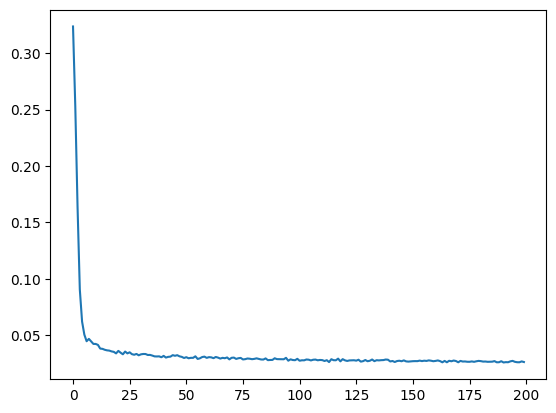

In [ ]:
import matplotlib.pyplot as plt
plt.plot(epoch_loss_list)
plt.show()

In [ ]:
# 마지막의 sequence_len 개를 가지고 학습
sequence_len = 10
last_number = torch.FloatTensor( lotto_dataset.data[-sequence_len:] ).unsqueeze(0).to(device)
# print(last_number.shape)
lotto_model.eval()
with torch.no_grad():
  prediction = lotto_model(last_number)
  preds = list(map(int,prediction[0]*44+1))
print(preds)

[7, 13, 19, 26, 33, 39]


LSTM
```
장기의존성 문제 해결
기울기 소실  문제 완화
시계열에서는 RNN 보다는 성능이 향상
```

In [ ]:
class LottoLSTM(nn.Module):
  def __init__(self,input_size=6, hidden_size=64,num_layers=3):
    super().__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    # RNN
    self.lstm = nn.LSTM(input_size=input_size,hidden_size=hidden_size
                      ,num_layers=num_layers,batch_first=True,dropout=0.2)
    # 분류기
    self.fc = nn.Sequential(
        nn.Linear(in_features=hidden_size,out_features=128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(in_features=128,out_features=64),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(in_features=64,out_features=6),
    )
  def forward(self,x):
    # 초기 은닉상태
    h0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(device)
    # 초기 셀상태 설정
    c0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(device)
    out, (hn,cn) = self.lstm(x,(h0,c0))  # 출력(batch_size, sequence_len, hidden_size)  (30, 10, 64)
    # 각 배치마다 10개의 시점있고. 각 시점마다 64개의 은닉상태가 있다
    # 마지막 시점의 출력  (30,64)   과거의 정보가 점점쌓여서 마지막에는 거의 모든 정보를 가지고 있다고
    out = out[:,-1,:]  # (30,64)  (sequence_len, hidden_size)
    out = self.fc(out)
    return out
# 데이터셋
# 데이터 로더
dataset = LottoDataSet('/content/drive/MyDrive/data/lotto.xlsx')
dataloader = DataLoader(dataset,batch_size=32)
# 모델
lstm_model = LottoLSTM(hidden_size=128,num_layers=10)
# 학습
lr = 1e-4
epochs = 200

loss_fn = nn.MSELoss()
optim = torch.optim.Adam(lstm_model.parameters(),lr=1e-4)

lstm_model.to(device)
epoch_loss_list = []
for epoch in range(epochs):
  iterator = tqdm(dataloader)
  epoch_loss = 0.0
  for data, label in iterator:
    data,label = data.to(device), label.to(device)
    pred = lstm_model(data)
    loss = loss_fn(pred,label)
    loss.backward()
    optim.step()
    optim.zero_grad()
    epoch_loss += loss.item()
    iterator.set_description(f'loss : {loss.item() / len(lotto_dataloader)}')
  epoch_loss_list.append(epoch_loss / len(lotto_dataloader) )
  print(f"epoch : {epoch+1} loss : {epoch_loss / len(lotto_dataloader.dataset)}")

loss : 0.01572839419047038: 100%|██████████| 18/18 [00:01<00:00,  9.45it/s]


epoch : 1 loss : 0.008503912834169196


loss : 0.01418348319000668: 100%|██████████| 18/18 [00:01<00:00,  9.98it/s]


epoch : 2 loss : 0.007788451321476655


loss : 0.010259815388255648: 100%|██████████| 18/18 [00:02<00:00,  6.89it/s]


epoch : 3 loss : 0.006466488266805951


loss : 0.0035514806707700095: 100%|██████████| 18/18 [00:02<00:00,  8.09it/s]


epoch : 4 loss : 0.002732114450965854


loss : 0.0027186512533161375: 100%|██████████| 18/18 [00:01<00:00, 10.25it/s]


epoch : 5 loss : 0.0014757088472624478


loss : 0.0021592086801926294: 100%|██████████| 18/18 [00:01<00:00, 10.45it/s]


epoch : 6 loss : 0.0013149882526063232


loss : 0.0026467328684197534: 100%|██████████| 18/18 [00:01<00:00, 10.12it/s]


epoch : 7 loss : 0.0013125616279866198


loss : 0.002032113571961721: 100%|██████████| 18/18 [00:01<00:00, 10.20it/s]


epoch : 8 loss : 0.001225614210041307


loss : 0.0029899662153588403: 100%|██████████| 18/18 [00:01<00:00, 10.31it/s]


epoch : 9 loss : 0.0012471016342316171


loss : 0.0020205817288822597: 100%|██████████| 18/18 [00:02<00:00,  7.48it/s]


epoch : 10 loss : 0.0012148425833945222


loss : 0.0027437566055191886: 100%|██████████| 18/18 [00:02<00:00,  7.06it/s]


epoch : 11 loss : 0.0011957551473282652


loss : 0.0024792562342352336: 100%|██████████| 18/18 [00:01<00:00, 10.23it/s]


epoch : 12 loss : 0.0011934715778761202


loss : 0.002250018840034803: 100%|██████████| 18/18 [00:01<00:00, 10.13it/s]


epoch : 13 loss : 0.0012052860714012771


loss : 0.002748384243912167: 100%|██████████| 18/18 [00:01<00:00,  9.83it/s]


epoch : 14 loss : 0.0011780585410247604


loss : 0.002688258265455564: 100%|██████████| 18/18 [00:01<00:00,  9.78it/s]


epoch : 15 loss : 0.0012148173472328152


loss : 0.0030531351351075703: 100%|██████████| 18/18 [00:01<00:00,  9.85it/s]


epoch : 16 loss : 0.0011721439726597113


loss : 0.002315046058760749: 100%|██████████| 18/18 [00:02<00:00,  7.62it/s]


epoch : 17 loss : 0.0011457670044502338


loss : 0.0028199369294775855: 100%|██████████| 18/18 [00:02<00:00,  6.80it/s]


epoch : 18 loss : 0.0011307905367810092


loss : 0.0016522157109445995: 100%|██████████| 18/18 [00:01<00:00,  9.91it/s]


epoch : 19 loss : 0.0010616276949215278


loss : 0.002328812455137571: 100%|██████████| 18/18 [00:01<00:00, 10.26it/s]


epoch : 20 loss : 0.0011490862213557572


loss : 0.0016829102403587764: 100%|██████████| 18/18 [00:01<00:00, 10.18it/s]


epoch : 21 loss : 0.0010831064457516018


loss : 0.0018468594385517968: 100%|██████████| 18/18 [00:01<00:00,  9.92it/s]


epoch : 22 loss : 0.0011241242470447536


loss : 0.00205586271153556: 100%|██████████| 18/18 [00:01<00:00, 10.07it/s]


epoch : 23 loss : 0.001116688065096843


loss : 0.002313472330570221: 100%|██████████| 18/18 [00:02<00:00,  8.53it/s]


epoch : 24 loss : 0.0010642347482146977


loss : 0.0018332497113280827: 100%|██████████| 18/18 [00:02<00:00,  6.98it/s]


epoch : 25 loss : 0.001052975560799777


loss : 0.002216900181439188: 100%|██████████| 18/18 [00:02<00:00,  8.75it/s]


epoch : 26 loss : 0.0010685839040352285


loss : 0.0018595330831077364: 100%|██████████| 18/18 [00:01<00:00, 10.37it/s]


epoch : 27 loss : 0.0010296768750057376


loss : 0.0019171275198459625: 100%|██████████| 18/18 [00:01<00:00, 10.05it/s]


epoch : 28 loss : 0.0010419405876196546


loss : 0.0013482201223572095: 100%|██████████| 18/18 [00:01<00:00, 10.03it/s]


epoch : 29 loss : 0.0009724011095307714


loss : 0.0020858392947249943: 100%|██████████| 18/18 [00:01<00:00,  9.83it/s]


epoch : 30 loss : 0.0010446808568918876


loss : 0.0017735395166609022: 100%|██████████| 18/18 [00:01<00:00,  9.46it/s]


epoch : 31 loss : 0.0010027313712153503


loss : 0.0020000069505638545: 100%|██████████| 18/18 [00:02<00:00,  6.32it/s]


epoch : 32 loss : 0.001049013965823453


loss : 0.00155705027282238: 100%|██████████| 18/18 [00:02<00:00,  7.97it/s]


epoch : 33 loss : 0.0009750699182208494


loss : 0.0023739441401428646: 100%|██████████| 18/18 [00:01<00:00, 10.22it/s]


epoch : 34 loss : 0.0009864042044061122


loss : 0.0018455789734919865: 100%|██████████| 18/18 [00:01<00:00, 10.04it/s]


epoch : 35 loss : 0.0009840210906410817


loss : 0.0017217239364981651: 100%|██████████| 18/18 [00:01<00:00, 10.20it/s]


epoch : 36 loss : 0.0009496264266882011


loss : 0.0017505308820141687: 100%|██████████| 18/18 [00:01<00:00, 10.05it/s]


epoch : 37 loss : 0.0009584385104370203


loss : 0.0016524186357855797: 100%|██████████| 18/18 [00:01<00:00,  9.77it/s]


epoch : 38 loss : 0.0009574896133364105


loss : 0.001373422539068593: 100%|██████████| 18/18 [00:02<00:00,  6.60it/s]


epoch : 39 loss : 0.0009492539881105474


loss : 0.0017835588918791877: 100%|██████████| 18/18 [00:02<00:00,  6.38it/s]


epoch : 40 loss : 0.0009783129944807762


loss : 0.0013304663201173146: 100%|██████████| 18/18 [00:01<00:00,  9.95it/s]


epoch : 41 loss : 0.0009286296922418711


loss : 0.001511111752026611: 100%|██████████| 18/18 [00:01<00:00,  9.83it/s]


epoch : 42 loss : 0.0009762519608727462


loss : 0.0018797626511918174: 100%|██████████| 18/18 [00:01<00:00, 10.22it/s]


epoch : 43 loss : 0.0009647279059876213


loss : 0.00197239075269964: 100%|██████████| 18/18 [00:02<00:00,  8.24it/s]


epoch : 44 loss : 0.0009824669544698952


loss : 0.0013914526336722905: 100%|██████████| 18/18 [00:02<00:00,  7.00it/s]


epoch : 45 loss : 0.0009571479519547748


loss : 0.0017770282510254118: 100%|██████████| 18/18 [00:02<00:00,  6.60it/s]


epoch : 46 loss : 0.0009457189455735598


loss : 0.001977335868610276: 100%|██████████| 18/18 [00:01<00:00,  9.32it/s]


epoch : 47 loss : 0.000983103516799726


loss : 0.0015711738831467098: 100%|██████████| 18/18 [00:01<00:00,  9.97it/s]


epoch : 48 loss : 0.0009577257170094003


loss : 0.0018195216026571062: 100%|██████████| 18/18 [00:01<00:00, 10.24it/s]


epoch : 49 loss : 0.000935913257890468


loss : 0.0017119263195329243: 100%|██████████| 18/18 [00:01<00:00, 10.11it/s]


epoch : 50 loss : 0.0009300858418879321


loss : 0.0017754284458027945: 100%|██████████| 18/18 [00:01<00:00,  9.58it/s]


epoch : 51 loss : 0.0009619306183333019


loss : 0.0014744653469986385: 100%|██████████| 18/18 [00:02<00:00,  8.18it/s]


epoch : 52 loss : 0.0009347703776878419


loss : 0.0016213390562269422: 100%|██████████| 18/18 [00:02<00:00,  6.66it/s]


epoch : 53 loss : 0.0009291241005759873


loss : 0.0015537585649225446: 100%|██████████| 18/18 [00:01<00:00,  9.01it/s]


epoch : 54 loss : 0.0009164171923193142


loss : 0.0015178467664453718: 100%|██████████| 18/18 [00:01<00:00,  9.76it/s]


epoch : 55 loss : 0.000910583340810786


loss : 0.001668233527905411: 100%|██████████| 18/18 [00:01<00:00,  9.58it/s]


epoch : 56 loss : 0.0009411981215419101


loss : 0.0018916668163405524: 100%|██████████| 18/18 [00:01<00:00,  9.33it/s]


epoch : 57 loss : 0.0009334531123582408


loss : 0.0021147187799215317: 100%|██████████| 18/18 [00:01<00:00,  9.81it/s]


epoch : 58 loss : 0.0009373470189438449


loss : 0.0014754728310638005: 100%|██████████| 18/18 [00:02<00:00,  8.04it/s]


epoch : 59 loss : 0.0009131469134000137


loss : 0.0018505870054165523: 100%|██████████| 18/18 [00:02<00:00,  6.46it/s]


epoch : 60 loss : 0.0009314936733127927


loss : 0.0015613320800993177: 100%|██████████| 18/18 [00:02<00:00,  8.84it/s]


epoch : 61 loss : 0.0009286154175458623


loss : 0.0015828458385335074: 100%|██████████| 18/18 [00:02<00:00,  8.59it/s]


epoch : 62 loss : 0.000927343468764703


loss : 0.0017720843768782085: 100%|██████████| 18/18 [00:01<00:00,  9.68it/s]


epoch : 63 loss : 0.0009219420222873739


loss : 0.0018011476430628034: 100%|██████████| 18/18 [00:01<00:00,  9.82it/s]


epoch : 64 loss : 0.0009768887878589922


loss : 0.0018124013311333126: 100%|██████████| 18/18 [00:01<00:00,  9.96it/s]


epoch : 65 loss : 0.0009148133476432279


loss : 0.001599503370622794: 100%|██████████| 18/18 [00:02<00:00,  7.58it/s]


epoch : 66 loss : 0.0009311591040530651


loss : 0.0016574105247855186: 100%|██████████| 18/18 [00:02<00:00,  6.76it/s]


epoch : 67 loss : 0.0008731325585797108


loss : 0.001318756594426102: 100%|██████████| 18/18 [00:01<00:00,  9.27it/s]


epoch : 68 loss : 0.0008574043259882241


loss : 0.0017949853920274312: 100%|██████████| 18/18 [00:01<00:00,  9.87it/s]


epoch : 69 loss : 0.0009062573843025903


loss : 0.001528115425672796: 100%|██████████| 18/18 [00:01<00:00, 10.04it/s]


epoch : 70 loss : 0.0009145485471746476


loss : 0.001576096233394411: 100%|██████████| 18/18 [00:01<00:00,  9.83it/s]


epoch : 71 loss : 0.0009072115443807711


loss : 0.0019489203890164692: 100%|██████████| 18/18 [00:01<00:00, 10.04it/s]


epoch : 72 loss : 0.0009311810202842994


loss : 0.0015570526528689596: 100%|██████████| 18/18 [00:02<00:00,  8.31it/s]


epoch : 73 loss : 0.0008994406893206157


loss : 0.0015693073057466084: 100%|██████████| 18/18 [00:02<00:00,  6.63it/s]


epoch : 74 loss : 0.0009201699767342145


loss : 0.0017963200807571411: 100%|██████████| 18/18 [00:02<00:00,  8.93it/s]


epoch : 75 loss : 0.000877484022606191


loss : 0.0016698671711815728: 100%|██████████| 18/18 [00:01<00:00,  9.67it/s]


epoch : 76 loss : 0.000907044328427572


loss : 0.0017294230767422253: 100%|██████████| 18/18 [00:01<00:00,  9.82it/s]


epoch : 77 loss : 0.0008994109037486341


loss : 0.001804693498545223: 100%|██████████| 18/18 [00:01<00:00,  9.95it/s]


epoch : 78 loss : 0.0009118799830404974


loss : 0.0016953437071707514: 100%|██████████| 18/18 [00:01<00:00,  9.96it/s]


epoch : 79 loss : 0.0009221402666926813


loss : 0.0017509832978248596: 100%|██████████| 18/18 [00:02<00:00,  8.20it/s]


epoch : 80 loss : 0.0009110930757664091


loss : 0.0015724021941423416: 100%|██████████| 18/18 [00:02<00:00,  6.69it/s]


epoch : 81 loss : 0.000888137183681452


loss : 0.0014323725675543149: 100%|██████████| 18/18 [00:02<00:00,  8.82it/s]


epoch : 82 loss : 0.0008868480188329871


loss : 0.0014196352826224433: 100%|██████████| 18/18 [00:01<00:00,  9.73it/s]


epoch : 83 loss : 0.0008910861429121855


loss : 0.0015686216453711193: 100%|██████████| 18/18 [00:01<00:00,  9.89it/s]


epoch : 84 loss : 0.0008617642322193375


loss : 0.0017594684743218953: 100%|██████████| 18/18 [00:02<00:00,  8.76it/s]


epoch : 85 loss : 0.0008889448246081098


loss : 0.00152998852233092: 100%|██████████| 18/18 [00:01<00:00,  9.73it/s]


epoch : 86 loss : 0.0008997992652622488


loss : 0.0018134326156642702: 100%|██████████| 18/18 [00:02<00:00,  8.26it/s]


epoch : 87 loss : 0.000886441027517799


loss : 0.0018020702732933892: 100%|██████████| 18/18 [00:02<00:00,  6.77it/s]


epoch : 88 loss : 0.0009072161540925074


loss : 0.001685365310145749: 100%|██████████| 18/18 [00:01<00:00,  9.01it/s]


epoch : 89 loss : 0.0009205803884823117


loss : 0.001872454666429096: 100%|██████████| 18/18 [00:01<00:00,  9.89it/s]


epoch : 90 loss : 0.0008643128466959909


loss : 0.001748974124590556: 100%|██████████| 18/18 [00:01<00:00, 10.03it/s]


epoch : 91 loss : 0.0008827155027136528


loss : 0.0016503216077884038: 100%|██████████| 18/18 [00:01<00:00, 10.07it/s]


epoch : 92 loss : 0.0008789471203206683


loss : 0.0019196603033277723: 100%|██████████| 18/18 [00:01<00:00, 10.15it/s]


epoch : 93 loss : 0.0008773330344463424


loss : 0.001404772512614727: 100%|██████████| 18/18 [00:02<00:00,  8.83it/s]


epoch : 94 loss : 0.0008343216065290591


loss : 0.0015105637204315928: 100%|██████████| 18/18 [00:02<00:00,  6.71it/s]


epoch : 95 loss : 0.0008611552544581376


loss : 0.0016212038074930508: 100%|██████████| 18/18 [00:02<00:00,  8.13it/s]


epoch : 96 loss : 0.0008917790268072121


loss : 0.0015163418526450794: 100%|██████████| 18/18 [00:01<00:00, 10.10it/s]


epoch : 97 loss : 0.0008865519051553962


loss : 0.0016516494668192333: 100%|██████████| 18/18 [00:01<00:00, 10.02it/s]


epoch : 98 loss : 0.0008484936828503935


loss : 0.0019532694584793514: 100%|██████████| 18/18 [00:01<00:00, 10.01it/s]


epoch : 99 loss : 0.0008937458661820391


loss : 0.0019816820406251484: 100%|██████████| 18/18 [00:01<00:00, 10.11it/s]


epoch : 100 loss : 0.0008879288052805036


loss : 0.0016038630985551411: 100%|██████████| 18/18 [00:01<00:00,  9.49it/s]


epoch : 101 loss : 0.000873453452807965


loss : 0.0014224238693714142: 100%|██████████| 18/18 [00:02<00:00,  6.71it/s]


epoch : 102 loss : 0.0008795945972150608


loss : 0.001766926712459988: 100%|██████████| 18/18 [00:02<00:00,  7.89it/s]


epoch : 103 loss : 0.0008686930711696045


loss : 0.0013701387991507847: 100%|██████████| 18/18 [00:01<00:00, 10.15it/s]


epoch : 104 loss : 0.000856029074103069


loss : 0.001626427181892925: 100%|██████████| 18/18 [00:01<00:00,  9.99it/s]


epoch : 105 loss : 0.0008779252819020114


loss : 0.0019388130555550258: 100%|██████████| 18/18 [00:01<00:00,  9.64it/s]


epoch : 106 loss : 0.0008897928206129469


loss : 0.0015604418391982715: 100%|██████████| 18/18 [00:01<00:00,  9.72it/s]


epoch : 107 loss : 0.0008958777071063896


loss : 0.0016028261226084498: 100%|██████████| 18/18 [00:01<00:00,  9.68it/s]


epoch : 108 loss : 0.0008897426531469222


loss : 0.00179896027677589: 100%|██████████| 18/18 [00:02<00:00,  6.75it/s]


epoch : 109 loss : 0.0008886615618420162


loss : 0.0014311261475086212: 100%|██████████| 18/18 [00:02<00:00,  7.67it/s]


epoch : 110 loss : 0.0008663062857155749


loss : 0.001736117112967703: 100%|██████████| 18/18 [00:01<00:00,  9.55it/s]


epoch : 111 loss : 0.0008467172654412633


loss : 0.0016705134055680698: 100%|██████████| 18/18 [00:01<00:00,  9.63it/s]


epoch : 112 loss : 0.0008986030852676725


loss : 0.0021410642398728263: 100%|██████████| 18/18 [00:01<00:00,  9.59it/s]


epoch : 113 loss : 0.0008502162745048245


loss : 0.0015797215617365306: 100%|██████████| 18/18 [00:01<00:00,  9.87it/s]


epoch : 114 loss : 0.0008695383301580981


loss : 0.0014658122219973141: 100%|██████████| 18/18 [00:01<00:00, 10.04it/s]


epoch : 115 loss : 0.0008552866291067154


loss : 0.0015027747592992252: 100%|██████████| 18/18 [00:02<00:00,  6.61it/s]


epoch : 116 loss : 0.0008707640913697027


loss : 0.0013363935674230258: 100%|██████████| 18/18 [00:02<00:00,  7.61it/s]


epoch : 117 loss : 0.0008717469247929055


loss : 0.0013688050417436494: 100%|██████████| 18/18 [00:01<00:00,  9.51it/s]


epoch : 118 loss : 0.0008617829156222103


loss : 0.0016797063872218132: 100%|██████████| 18/18 [00:01<00:00,  9.25it/s]


epoch : 119 loss : 0.0008716115647618719


loss : 0.0014179208212428624: 100%|██████████| 18/18 [00:01<00:00,  9.40it/s]


epoch : 120 loss : 0.000838712658465123


loss : 0.0017987069570355946: 100%|██████████| 18/18 [00:01<00:00, 10.09it/s]


epoch : 121 loss : 0.0008173702693403625


loss : 0.001688135787844658: 100%|██████████| 18/18 [00:01<00:00,  9.97it/s]


epoch : 122 loss : 0.0008657974117308212


loss : 0.0020044686065779794: 100%|██████████| 18/18 [00:02<00:00,  6.90it/s]


epoch : 123 loss : 0.0008719369112480459


loss : 0.0014875134867098597: 100%|██████████| 18/18 [00:02<00:00,  7.64it/s]


epoch : 124 loss : 0.0008715133738817928


loss : 0.001408446580171585: 100%|██████████| 18/18 [00:01<00:00, 10.02it/s]


epoch : 125 loss : 0.0008482532676228945


loss : 0.0017420972386995952: 100%|██████████| 18/18 [00:01<00:00,  9.93it/s]


epoch : 126 loss : 0.0008629372933035274


loss : 0.0016869583891497718: 100%|██████████| 18/18 [00:01<00:00, 10.08it/s]


epoch : 127 loss : 0.0008920524436846482


loss : 0.0016644717090659672: 100%|██████████| 18/18 [00:01<00:00,  9.95it/s]


epoch : 128 loss : 0.0008614787617497307


loss : 0.0017989176428980297: 100%|██████████| 18/18 [00:01<00:00,  9.80it/s]


epoch : 129 loss : 0.0008600552519448369


loss : 0.0017414680785602992: 100%|██████████| 18/18 [00:02<00:00,  7.10it/s]


epoch : 130 loss : 0.0008861150612666024


loss : 0.001640395468307866: 100%|██████████| 18/18 [00:02<00:00,  7.05it/s]


epoch : 131 loss : 0.000856747311412645


loss : 0.001722353303598033: 100%|██████████| 18/18 [00:01<00:00,  9.98it/s]


epoch : 132 loss : 0.0008567845475652235


loss : 0.001907617681556278: 100%|██████████| 18/18 [00:01<00:00, 10.05it/s]


epoch : 133 loss : 0.0008844220106282251


loss : 0.0013975114044215945: 100%|██████████| 18/18 [00:01<00:00, 10.07it/s]


epoch : 134 loss : 0.0008746390766966686


loss : 0.0016330215666029188: 100%|██████████| 18/18 [00:01<00:00,  9.97it/s]


epoch : 135 loss : 0.0008375798385563514


loss : 0.0014659004906813304: 100%|██████████| 18/18 [00:01<00:00,  9.93it/s]


epoch : 136 loss : 0.0008514074863289758


loss : 0.0014951527118682861: 100%|██████████| 18/18 [00:02<00:00,  7.51it/s]


epoch : 137 loss : 0.0008501860031710683


loss : 0.001523624277777142: 100%|██████████| 18/18 [00:02<00:00,  6.71it/s]


epoch : 138 loss : 0.0008283228874742556


loss : 0.0012561211155520545: 100%|██████████| 18/18 [00:01<00:00, 10.15it/s]


epoch : 139 loss : 0.000856151017058882


loss : 0.0016834984223047893: 100%|██████████| 18/18 [00:01<00:00,  9.96it/s]


epoch : 140 loss : 0.0008459564284991017


loss : 0.0013246748389469252: 100%|██████████| 18/18 [00:01<00:00,  9.85it/s]


epoch : 141 loss : 0.0008513889168288639


loss : 0.0016523476483093367: 100%|██████████| 18/18 [00:01<00:00, 10.05it/s]


epoch : 142 loss : 0.000852283023351388


loss : 0.0015868721529841423: 100%|██████████| 18/18 [00:01<00:00, 10.01it/s]


epoch : 143 loss : 0.0008416709108211153


loss : 0.001611233688890934: 100%|██████████| 18/18 [00:02<00:00,  7.91it/s]


epoch : 144 loss : 0.0008525196931881013


loss : 0.0012985921154419582: 100%|██████████| 18/18 [00:02<00:00,  6.36it/s]


epoch : 145 loss : 0.0008355946038856352


loss : 0.0017182330290476482: 100%|██████████| 18/18 [00:02<00:00,  8.19it/s]


epoch : 146 loss : 0.0008589589847720784


loss : 0.0015535573992464277: 100%|██████████| 18/18 [00:02<00:00,  8.90it/s]


epoch : 147 loss : 0.0008418985588891472


loss : 0.001641910005774763: 100%|██████████| 18/18 [00:01<00:00,  9.17it/s]


epoch : 148 loss : 0.0008378487797252995


loss : 0.0015010713703102535: 100%|██████████| 18/18 [00:01<00:00,  9.11it/s]


epoch : 149 loss : 0.0008648212416191324


loss : 0.001463941919306914: 100%|██████████| 18/18 [00:01<00:00,  9.21it/s]


epoch : 150 loss : 0.0008261583028562206


loss : 0.0014380370784136984: 100%|██████████| 18/18 [00:02<00:00,  6.47it/s]


epoch : 151 loss : 0.0008384374124433497


loss : 0.0014411695301532745: 100%|██████████| 18/18 [00:03<00:00,  5.55it/s]


epoch : 152 loss : 0.0008392896999022086


loss : 0.00130237794170777: 100%|██████████| 18/18 [00:02<00:00,  6.23it/s]


epoch : 153 loss : 0.0008324795945299615


loss : 0.001572679728269577: 100%|██████████| 18/18 [00:01<00:00,  9.71it/s]


epoch : 154 loss : 0.0008718180838677523


loss : 0.0014967963927321965: 100%|██████████| 18/18 [00:01<00:00,  9.56it/s]


epoch : 155 loss : 0.0008653268894756869


loss : 0.0013582253207763035: 100%|██████████| 18/18 [00:01<00:00,  9.60it/s]


epoch : 156 loss : 0.0008437131973747298


loss : 0.0021175978084405265: 100%|██████████| 18/18 [00:02<00:00,  6.91it/s]


epoch : 157 loss : 0.0008739461626509111


loss : 0.001375224648250474: 100%|██████████| 18/18 [00:02<00:00,  6.87it/s]


epoch : 158 loss : 0.00083271299468742


loss : 0.0013533849269151688: 100%|██████████| 18/18 [00:01<00:00,  9.57it/s]


epoch : 159 loss : 0.0008370314369634758


loss : 0.0014141428594787915: 100%|██████████| 18/18 [00:01<00:00,  9.60it/s]


epoch : 160 loss : 0.0008468960190741278


loss : 0.0017747363696495693: 100%|██████████| 18/18 [00:01<00:00,  9.46it/s]


epoch : 161 loss : 0.0008675077052371536


loss : 0.001776975476079517: 100%|██████████| 18/18 [00:01<00:00,  9.85it/s]


epoch : 162 loss : 0.0008434009999572802


loss : 0.0017303734396894772: 100%|██████████| 18/18 [00:01<00:00,  9.44it/s]


epoch : 163 loss : 0.0008399432203430924


loss : 0.0018992148753669527: 100%|██████████| 18/18 [00:02<00:00,  6.90it/s]


epoch : 164 loss : 0.0008659784266684982


loss : 0.001398647100561195: 100%|██████████| 18/18 [00:02<00:00,  7.12it/s]


epoch : 165 loss : 0.0008391055894894995


loss : 0.0015416486809651058: 100%|██████████| 18/18 [00:01<00:00, 10.13it/s]


epoch : 166 loss : 0.0008389975493706816


loss : 0.0016145481624537045: 100%|██████████| 18/18 [00:01<00:00,  9.64it/s]


epoch : 167 loss : 0.0008279899229034246


loss : 0.0016487404290172788: 100%|██████████| 18/18 [00:01<00:00,  9.96it/s]


epoch : 168 loss : 0.0008502036212481183


loss : 0.001330588116414017: 100%|██████████| 18/18 [00:01<00:00,  9.89it/s]


epoch : 169 loss : 0.0008399764162977393


loss : 0.0014533561964829762: 100%|██████████| 18/18 [00:01<00:00,  9.86it/s]


epoch : 170 loss : 0.0008131598939837741


loss : 0.0016061658453610209: 100%|██████████| 18/18 [00:02<00:00,  7.65it/s]


epoch : 171 loss : 0.0008221115923667554


loss : 0.0011988913433419333: 100%|██████████| 18/18 [00:02<00:00,  6.39it/s]


epoch : 172 loss : 0.0008222550059930026


loss : 0.0016403690808349186: 100%|██████████| 18/18 [00:02<00:00,  8.94it/s]


epoch : 173 loss : 0.0008458342242369549


loss : 0.0014227352415521939: 100%|██████████| 18/18 [00:01<00:00,  9.38it/s]


epoch : 174 loss : 0.0008310272673265539


loss : 0.0012839043305979834: 100%|██████████| 18/18 [00:01<00:00,  9.69it/s]


epoch : 175 loss : 0.0008134750160221144


loss : 0.0018347930163145065: 100%|██████████| 18/18 [00:01<00:00,  9.91it/s]


epoch : 176 loss : 0.0008685288803397322


loss : 0.0017195620263616245: 100%|██████████| 18/18 [00:01<00:00,  9.84it/s]


epoch : 177 loss : 0.0008617943460992772


loss : 0.0014820596617129114: 100%|██████████| 18/18 [00:02<00:00,  7.60it/s]


epoch : 178 loss : 0.0008300277605492005


loss : 0.0016402037193377812: 100%|██████████| 18/18 [00:02<00:00,  6.55it/s]


epoch : 179 loss : 0.0008404439804311708


loss : 0.0013848581454820102: 100%|██████████| 18/18 [00:01<00:00,  9.24it/s]


epoch : 180 loss : 0.0008359941747709573


loss : 0.001496652244693703: 100%|██████████| 18/18 [00:01<00:00,  9.66it/s]


epoch : 181 loss : 0.0008050741848917745


loss : 0.0011646970071726376: 100%|██████████| 18/18 [00:01<00:00,  9.28it/s]


epoch : 182 loss : 0.0008299704741606181


loss : 0.0012981658801436424: 100%|██████████| 18/18 [00:01<00:00,  9.86it/s]


epoch : 183 loss : 0.0008285654869546993


loss : 0.0015144487842917442: 100%|██████████| 18/18 [00:01<00:00,  9.78it/s]


epoch : 184 loss : 0.0008191974639302963


loss : 0.0015440240709318055: 100%|██████████| 18/18 [00:02<00:00,  7.81it/s]


epoch : 185 loss : 0.0008333690913407493


loss : 0.0014600562345650461: 100%|██████████| 18/18 [00:02<00:00,  6.75it/s]


epoch : 186 loss : 0.0008163367022874115


loss : 0.0015738982086380322: 100%|██████████| 18/18 [00:01<00:00,  9.37it/s]


epoch : 187 loss : 0.0008114399120426007


loss : 0.001523008570075035: 100%|██████████| 18/18 [00:01<00:00,  9.98it/s]


epoch : 188 loss : 0.0008360724159174686


loss : 0.0018862924642033046: 100%|██████████| 18/18 [00:01<00:00,  9.89it/s]


epoch : 189 loss : 0.0008543963550770883


loss : 0.001442567031416628: 100%|██████████| 18/18 [00:01<00:00,  9.50it/s]


epoch : 190 loss : 0.0008375542774367676


loss : 0.0016747551659742992: 100%|██████████| 18/18 [00:03<00:00,  4.54it/s]


epoch : 191 loss : 0.0008786149865699758


loss : 0.0016808086592290136: 100%|██████████| 18/18 [00:05<00:00,  3.29it/s]


epoch : 192 loss : 0.0008518003771523778


loss : 0.0015347346456514464: 100%|██████████| 18/18 [00:03<00:00,  5.25it/s]


epoch : 193 loss : 0.0008093808080813439


loss : 0.0013057109382417467: 100%|██████████| 18/18 [00:03<00:00,  5.84it/s]


epoch : 194 loss : 0.0008200171718494497


loss : 0.0015761007865269978: 100%|██████████| 18/18 [00:01<00:00,  9.83it/s]


epoch : 195 loss : 0.0008393043230066626


loss : 0.0019617432521449197: 100%|██████████| 18/18 [00:02<00:00,  7.05it/s]


epoch : 196 loss : 0.0008313037696287786


loss : 0.0017087312622202768: 100%|██████████| 18/18 [00:02<00:00,  6.76it/s]


epoch : 197 loss : 0.000867984760150635


loss : 0.0014107500513394673: 100%|██████████| 18/18 [00:02<00:00,  8.73it/s]


epoch : 198 loss : 0.0008159276138213899


loss : 0.0017415804581509696: 100%|██████████| 18/18 [00:01<00:00,  9.70it/s]


epoch : 199 loss : 0.0008307076260286698


loss : 0.0014931118736664455: 100%|██████████| 18/18 [00:01<00:00,  9.81it/s]

epoch : 200 loss : 0.0008187315547369796


In [ ]:
# 마지막의 sequence_len 개를 가지고 학습

last_number = torch.FloatTensor( dataset.data[-sequence_len:] ).unsqueeze(0).to(device)
# print(last_number.shape)
lstm_model.eval()
with torch.no_grad():
  prediction = lstm_model(last_number)
  preds = list(map(int,prediction[0]*44+1))
print(preds)
# [7, 13, 19, 26, 33, 39] RNN
# [7, 13, 20, 26, 32, 39] LSTM

[7, 13, 20, 26, 32, 39]


GRU
```
LSTM의 단순화 버전
LSTM (input,forget,output) gate
GRU(reset, update) gate
Reset Gate : 이전정보를 얼마나 잊을지
Update Gate : 새로운 정보를 얼마나 저장할지
```

In [ ]:
class LottoGRU(nn.Module):
  def __init__(self,input_size=6, hidden_size=64,num_layers=3):
    super().__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    # RNN
    self.gru = nn.GRU(input_size=input_size,hidden_size=hidden_size
                      ,num_layers=num_layers,batch_first=True,dropout=0.2)
    # 분류기
    self.fc = nn.Sequential(
        nn.Linear(in_features=hidden_size,out_features=128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(in_features=128,out_features=64),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(in_features=64,out_features=6),
    )
  def forward(self,x):
    # 초기 은닉상태
    h0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(device)
    out, hn = self.gru(x,h0)  # 출력(batch_size, sequence_len, hidden_size)  (30, 10, 64)
    # 각 배치마다 10개의 시점있고. 각 시점마다 64개의 은닉상태가 있다
    # 마지막 시점의 출력  (30,64)   과거의 정보가 점점쌓여서 마지막에는 거의 모든 정보를 가지고 있다고
    out = out[:,-1,:]  # (30,64)  (sequence_len, hidden_size)
    out = self.fc(out)
    return out
# 데이터셋
# 데이터 로더
sequence_len = 10
dataset = LottoDataSet('/content/drive/MyDrive/data/lotto.xlsx',sequence_len=sequence_len)
dataloader = DataLoader(dataset,batch_size=32,shuffle=True)
# 모델
gru_model = LottoGRU(hidden_size=128,num_layers=20)
# 학습
lr = 1e-4
epochs = 200

loss_fn = nn.MSELoss()
optim = torch.optim.Adam(gru_model.parameters(),lr=1e-4)

gru_model.to(device)
epoch_loss_list = []
for epoch in range(epochs):
  iterator = tqdm(dataloader)
  epoch_loss = 0.0
  for data, label in iterator:
    data,label = data.to(device), label.to(device)
    pred = gru_model(data)
    loss = loss_fn(pred,label)
    loss.backward()
    optim.step()
    optim.zero_grad()
    epoch_loss += loss.item()
    iterator.set_description(f'loss : {loss.item() / len(lotto_dataloader)}')
  epoch_loss_list.append(epoch_loss / len(lotto_dataloader) )
  print(f"epoch : {epoch+1} loss : {epoch_loss / len(lotto_dataloader.dataset)}")

  # 마지막의 sequence_len 개를 가지고 학습
last_number = torch.FloatTensor( dataset.data[-sequence_len:] ).unsqueeze(0).to(device)
# print(last_number.shape)
gru_model.eval()
with torch.no_grad():
  prediction = gru_model(last_number)
  preds = list(map(int,prediction[0]*44+1))
print(preds)

with torch.no_grad():
  prediction = gru_model(last_number)
  preds = list(map(int,prediction[0]*44+1))
print(preds)

loss : 0.018276191420025296: 100%|██████████| 18/18 [00:03<00:00,  4.76it/s]


epoch : 1 loss : 0.010813918098700132


loss : 0.008583542373445299: 100%|██████████| 18/18 [00:05<00:00,  3.49it/s]


epoch : 2 loss : 0.00791255971617836


loss : 0.0037218183279037476: 100%|██████████| 18/18 [00:03<00:00,  4.59it/s]


epoch : 3 loss : 0.002864642115644843


loss : 0.002865217419134246: 100%|██████████| 18/18 [00:03<00:00,  4.62it/s]


epoch : 4 loss : 0.0016606356613606001


loss : 0.003486658963892195: 100%|██████████| 18/18 [00:04<00:00,  3.92it/s]


epoch : 5 loss : 0.0014645291572744899


loss : 0.0032975456366936364: 100%|██████████| 18/18 [00:04<00:00,  3.98it/s]


epoch : 6 loss : 0.0014215256723997404


loss : 0.002286376431584358: 100%|██████████| 18/18 [00:03<00:00,  4.70it/s]


epoch : 7 loss : 0.001411742577664286


loss : 0.0020214993920591143: 100%|██████████| 18/18 [00:03<00:00,  4.67it/s]


epoch : 8 loss : 0.001342476533203245


loss : 0.0018443423840734693: 100%|██████████| 18/18 [00:05<00:00,  3.52it/s]


epoch : 9 loss : 0.0013223467930722579


loss : 0.001860729522175259: 100%|██████████| 18/18 [00:03<00:00,  4.84it/s]


epoch : 10 loss : 0.0013327895522975235


loss : 0.002468890200058619: 100%|██████████| 18/18 [00:03<00:00,  4.81it/s]


epoch : 11 loss : 0.0012964686117530298


loss : 0.0023573732210530173: 100%|██████████| 18/18 [00:05<00:00,  3.53it/s]


epoch : 12 loss : 0.0012810798998412897


loss : 0.001939507822195689: 100%|██████████| 18/18 [00:04<00:00,  4.37it/s]


epoch : 13 loss : 0.0012999729440956237


loss : 0.0027083826975689996: 100%|██████████| 18/18 [00:03<00:00,  4.70it/s]


epoch : 14 loss : 0.0012660092312386996


loss : 0.0015194626111123296: 100%|██████████| 18/18 [00:04<00:00,  4.24it/s]


epoch : 15 loss : 0.0012507297152237926


loss : 0.0024471220870812735: 100%|██████████| 18/18 [00:04<00:00,  3.81it/s]


epoch : 16 loss : 0.00126426042519885


loss : 0.001989472450481521: 100%|██████████| 18/18 [00:03<00:00,  4.74it/s]


epoch : 17 loss : 0.0012948170183695478


loss : 0.0026743238170941672: 100%|██████████| 18/18 [00:03<00:00,  4.82it/s]


epoch : 18 loss : 0.0012050689928394427


loss : 0.0017869166202015346: 100%|██████████| 18/18 [00:05<00:00,  3.38it/s]


epoch : 19 loss : 0.0012012017663005446


loss : 0.0019791428413656023: 100%|██████████| 18/18 [00:03<00:00,  4.72it/s]


epoch : 20 loss : 0.0012070388539875154


loss : 0.001942013907763693: 100%|██████████| 18/18 [00:03<00:00,  4.87it/s]


epoch : 21 loss : 0.0011765431116918007


loss : 0.002365416329767969: 100%|██████████| 18/18 [00:05<00:00,  3.10it/s]


epoch : 22 loss : 0.0012384625453260734


loss : 0.00127948344581657: 100%|██████████| 18/18 [00:03<00:00,  4.63it/s]


epoch : 23 loss : 0.0011529598901008102


loss : 0.0014096210814184612: 100%|██████████| 18/18 [00:03<00:00,  4.76it/s]


epoch : 24 loss : 0.0011317048945444093


loss : 0.0016855586113201247: 100%|██████████| 18/18 [00:04<00:00,  3.75it/s]


epoch : 25 loss : 0.0011489354174503748


loss : 0.001502436792684926: 100%|██████████| 18/18 [00:04<00:00,  4.02it/s]


epoch : 26 loss : 0.0011089464528955145


loss : 0.0020028907391760084: 100%|██████████| 18/18 [00:03<00:00,  4.63it/s]


epoch : 27 loss : 0.001095729478025179


loss : 0.0017288868418998187: 100%|██████████| 18/18 [00:03<00:00,  4.53it/s]


epoch : 28 loss : 0.0011442261044498827


loss : 0.0018033288005325529: 100%|██████████| 18/18 [00:05<00:00,  3.47it/s]


epoch : 29 loss : 0.00107946128604545


loss : 0.0015514253949125607: 100%|██████████| 18/18 [00:03<00:00,  4.67it/s]


epoch : 30 loss : 0.001076450249810013


loss : 0.002425575421916114: 100%|██████████| 18/18 [00:04<00:00,  4.26it/s]


epoch : 31 loss : 0.0010926325323073556


loss : 0.0014489303446478313: 100%|██████████| 18/18 [00:05<00:00,  3.38it/s]


epoch : 32 loss : 0.0010435517589233332


loss : 0.0015031075518992213: 100%|██████████| 18/18 [00:04<00:00,  3.73it/s]


epoch : 33 loss : 0.0011281953628757874


loss : 0.0018565778930981953: 100%|██████████| 18/18 [00:03<00:00,  4.77it/s]


epoch : 34 loss : 0.0011683186187857776


loss : 0.001374790341489845: 100%|██████████| 18/18 [00:05<00:00,  3.49it/s]


epoch : 35 loss : 0.0010409722332474138


loss : 0.0028855426030026544: 100%|██████████| 18/18 [00:03<00:00,  4.71it/s]


epoch : 36 loss : 0.0011269644592895353


loss : 0.0018936950299474928: 100%|██████████| 18/18 [00:03<00:00,  4.73it/s]


epoch : 37 loss : 0.0010487140531537772


loss : 0.002963779494166374: 100%|██████████| 18/18 [00:04<00:00,  4.10it/s]


epoch : 38 loss : 0.001089916634875879


loss : 0.0021857420603434243: 100%|██████████| 18/18 [00:04<00:00,  3.93it/s]


epoch : 39 loss : 0.0010354393530342218


loss : 0.0021401457488536835: 100%|██████████| 18/18 [00:03<00:00,  4.81it/s]


epoch : 40 loss : 0.0010795050749568631


loss : 0.0023298271828227574: 100%|██████████| 18/18 [00:03<00:00,  4.71it/s]


epoch : 41 loss : 0.0010603156925694977


loss : 0.0015191466857989628: 100%|██████████| 18/18 [00:05<00:00,  3.40it/s]


epoch : 42 loss : 0.0010206121884340006


loss : 0.0016056646903355916: 100%|██████████| 18/18 [00:03<00:00,  4.77it/s]


epoch : 43 loss : 0.001069603641952971


loss : 0.0018885874499877293: 100%|██████████| 18/18 [00:03<00:00,  4.52it/s]


epoch : 44 loss : 0.0009970094861208106


loss : 0.001868222943610615: 100%|██████████| 18/18 [00:04<00:00,  3.68it/s]


epoch : 45 loss : 0.0010274492217589625


loss : 0.0011159552054272757: 100%|██████████| 18/18 [00:04<00:00,  4.44it/s]


epoch : 46 loss : 0.0010280936132285663


loss : 0.0018640021897024578: 100%|██████████| 18/18 [00:03<00:00,  4.67it/s]


epoch : 47 loss : 0.001038511648854549


loss : 0.0014934090690480338: 100%|██████████| 18/18 [00:04<00:00,  4.23it/s]


epoch : 48 loss : 0.0010135305790806846


loss : 0.0016394186144073803: 100%|██████████| 18/18 [00:04<00:00,  3.88it/s]


epoch : 49 loss : 0.0010276995699772303


loss : 0.0018852061281601589: 100%|██████████| 18/18 [00:03<00:00,  4.84it/s]


epoch : 50 loss : 0.0010309516043542958


loss : 0.0016647184060679541: 100%|██████████| 18/18 [00:03<00:00,  4.82it/s]


epoch : 51 loss : 0.0009982806710834556


loss : 0.0015813722792598936: 100%|██████████| 18/18 [00:05<00:00,  3.47it/s]


epoch : 52 loss : 0.0010290941183301184


loss : 0.0014041054786907302: 100%|██████████| 18/18 [00:03<00:00,  4.78it/s]


epoch : 53 loss : 0.0010303405160419375


loss : 0.0016886295957697763: 100%|██████████| 18/18 [00:03<00:00,  4.82it/s]


epoch : 54 loss : 0.0009942100845652519


loss : 0.0017760791298415926: 100%|██████████| 18/18 [00:04<00:00,  4.14it/s]


epoch : 55 loss : 0.000988827609597779


loss : 0.0015246795697344674: 100%|██████████| 18/18 [00:04<00:00,  3.96it/s]


epoch : 56 loss : 0.0010399368605006941


loss : 0.001600742857489321: 100%|██████████| 18/18 [00:03<00:00,  4.87it/s]


epoch : 57 loss : 0.0009764796591919961


loss : 0.001862232055928972: 100%|██████████| 18/18 [00:03<00:00,  4.75it/s]


epoch : 58 loss : 0.0009808624531778929


loss : 0.0016068489187293583: 100%|██████████| 18/18 [00:05<00:00,  3.45it/s]


epoch : 59 loss : 0.0009669917367613144


loss : 0.0020153348644574485: 100%|██████████| 18/18 [00:03<00:00,  4.86it/s]


epoch : 60 loss : 0.0009850678134629195


loss : 0.0013936603855755595: 100%|██████████| 18/18 [00:03<00:00,  4.72it/s]


epoch : 61 loss : 0.0010002751151274006


loss : 0.0017676307923263973: 100%|██████████| 18/18 [00:04<00:00,  3.88it/s]


epoch : 62 loss : 0.0010022648355568484


loss : 0.002027394250035286: 100%|██████████| 18/18 [00:04<00:00,  4.20it/s]


epoch : 63 loss : 0.0009623407419744155


loss : 0.001748313299483723: 100%|██████████| 18/18 [00:03<00:00,  4.67it/s]


epoch : 64 loss : 0.0009615069402636384


loss : 0.0013435643373264207: 100%|██████████| 18/18 [00:04<00:00,  4.40it/s]


epoch : 65 loss : 0.0009619268863428411


loss : 0.001787918930252393: 100%|██████████| 18/18 [00:04<00:00,  3.62it/s]


epoch : 66 loss : 0.0009908425192877972


loss : 0.0011379975411627027: 100%|██████████| 18/18 [00:03<00:00,  4.67it/s]


epoch : 67 loss : 0.0009680387677906228


loss : 0.0019944682717323303: 100%|██████████| 18/18 [00:03<00:00,  4.78it/s]


epoch : 68 loss : 0.0010055152987458295


loss : 0.0009613283392455843: 100%|██████████| 18/18 [00:05<00:00,  3.46it/s]


epoch : 69 loss : 0.0009063848381419833


loss : 0.002229851774043507: 100%|██████████| 18/18 [00:03<00:00,  4.72it/s]


epoch : 70 loss : 0.0009848171536870997


loss : 0.0014125352932347192: 100%|██████████| 18/18 [00:03<00:00,  4.71it/s]


epoch : 71 loss : 0.0009888693080585208


loss : 0.0014305284453762902: 100%|██████████| 18/18 [00:04<00:00,  4.13it/s]


epoch : 72 loss : 0.0009579044337913715


loss : 0.002166465338733461: 100%|██████████| 18/18 [00:04<00:00,  3.87it/s]


epoch : 73 loss : 0.000989542476725664


loss : 0.0009837377195556958: 100%|██████████| 18/18 [00:03<00:00,  4.73it/s]


epoch : 74 loss : 0.0009917992254276928


loss : 0.000995788723230362: 100%|██████████| 18/18 [00:03<00:00,  4.76it/s]


epoch : 75 loss : 0.0009693788739738705


loss : 0.0022199642327096728: 100%|██████████| 18/18 [00:04<00:00,  3.62it/s]


epoch : 76 loss : 0.0009997474136862823


loss : 0.0010684648942616251: 100%|██████████| 18/18 [00:03<00:00,  4.81it/s]


epoch : 77 loss : 0.0009266418378076536


loss : 0.0026909862127568987: 100%|██████████| 18/18 [00:03<00:00,  4.85it/s]


epoch : 78 loss : 0.0010034929451753767


loss : 0.0024709122048483956: 100%|██████████| 18/18 [00:04<00:00,  3.77it/s]


epoch : 79 loss : 0.0010019131172314393


loss : 0.0018348110218842824: 100%|██████████| 18/18 [00:03<00:00,  4.54it/s]


epoch : 80 loss : 0.000969636719673872


loss : 0.002238100601567162: 100%|██████████| 18/18 [00:03<00:00,  4.78it/s]


epoch : 81 loss : 0.0009359641087730582


loss : 0.0021835948444075054: 100%|██████████| 18/18 [00:04<00:00,  4.24it/s]


epoch : 82 loss : 0.0009545449991609982


loss : 0.001318517348004712: 100%|██████████| 18/18 [00:04<00:00,  3.84it/s]


epoch : 83 loss : 0.0009350365784903653


loss : 0.0012981374230649737: 100%|██████████| 18/18 [00:03<00:00,  4.59it/s]


epoch : 84 loss : 0.00092139432086147


loss : 0.0012658231167329682: 100%|██████████| 18/18 [00:03<00:00,  4.72it/s]


epoch : 85 loss : 0.0009525539721998808


loss : 0.001353642489347193: 100%|██████████| 18/18 [00:05<00:00,  3.54it/s]


epoch : 86 loss : 0.0009510831156973359


loss : 0.0015592333964175647: 100%|██████████| 18/18 [00:03<00:00,  4.77it/s]


epoch : 87 loss : 0.0009208939192320803


loss : 0.0014047062852316433: 100%|██████████| 18/18 [00:03<00:00,  4.63it/s]


epoch : 88 loss : 0.0009539731201990474


loss : 0.0015363588722215758: 100%|██████████| 18/18 [00:05<00:00,  3.56it/s]


epoch : 89 loss : 0.0009467889179589508


loss : 0.0016600295073456233: 100%|██████████| 18/18 [00:03<00:00,  4.69it/s]


epoch : 90 loss : 0.0009625407786731669


loss : 0.002280930678049723: 100%|██████████| 18/18 [00:03<00:00,  4.59it/s]


epoch : 91 loss : 0.000998799086099477


loss : 0.0019157462649875218: 100%|██████████| 18/18 [00:04<00:00,  4.01it/s]


epoch : 92 loss : 0.0009482170341254996


loss : 0.0009972882560557788: 100%|██████████| 18/18 [00:04<00:00,  4.08it/s]


epoch : 93 loss : 0.0009639898328472385


loss : 0.0017115738656785754: 100%|██████████| 18/18 [00:03<00:00,  4.51it/s]


epoch : 94 loss : 0.0009502263190291769


loss : 0.001152603059179253: 100%|██████████| 18/18 [00:04<00:00,  4.31it/s]


epoch : 95 loss : 0.0009038994664982926


loss : 0.00143584536595477: 100%|██████████| 18/18 [00:05<00:00,  3.54it/s]


epoch : 96 loss : 0.0009419163789519732


loss : 0.0024755410850048065: 100%|██████████| 18/18 [00:04<00:00,  4.37it/s]


epoch : 97 loss : 0.0009805482122109091


loss : 0.0010604407224390241: 100%|██████████| 18/18 [00:03<00:00,  4.80it/s]


epoch : 98 loss : 0.0009161456950384078


loss : 0.0010927674464053577: 100%|██████████| 18/18 [00:05<00:00,  3.52it/s]


epoch : 99 loss : 0.0009098250398800956


loss : 0.0019601014339261586: 100%|██████████| 18/18 [00:03<00:00,  4.74it/s]


epoch : 100 loss : 0.0009203815511126313


loss : 0.0014816811308264732: 100%|██████████| 18/18 [00:03<00:00,  4.83it/s]


epoch : 101 loss : 0.0009223231275251014


loss : 0.001264648512005806: 100%|██████████| 18/18 [00:04<00:00,  3.70it/s]


epoch : 102 loss : 0.0009492262226375315


loss : 0.000967698378695382: 100%|██████████| 18/18 [00:04<00:00,  4.31it/s]


epoch : 103 loss : 0.000934401637599837


loss : 0.0017144402696026696: 100%|██████████| 18/18 [00:03<00:00,  4.83it/s]


epoch : 104 loss : 0.0009348562302188479


loss : 0.0015642186626791954: 100%|██████████| 18/18 [00:04<00:00,  4.23it/s]


epoch : 105 loss : 0.0009234501417431471


loss : 0.0013279099431302813: 100%|██████████| 18/18 [00:04<00:00,  3.90it/s]


epoch : 106 loss : 0.0009321002825665817


loss : 0.0014521276785267724: 100%|██████████| 18/18 [00:03<00:00,  4.84it/s]


epoch : 107 loss : 0.0008827107790991557


loss : 0.002333769988682535: 100%|██████████| 18/18 [00:03<00:00,  4.64it/s]


epoch : 108 loss : 0.0009646015442747007


loss : 0.001820743911796146: 100%|██████████| 18/18 [00:05<00:00,  3.52it/s]


epoch : 109 loss : 0.0009115612663650255


loss : 0.001538609258002705: 100%|██████████| 18/18 [00:03<00:00,  4.74it/s]


epoch : 110 loss : 0.0009340297484355007


loss : 0.0013550350235568152: 100%|██████████| 18/18 [00:03<00:00,  4.62it/s]


epoch : 111 loss : 0.0009333718561386462


loss : 0.0015417789626452657: 100%|██████████| 18/18 [00:04<00:00,  3.75it/s]


epoch : 112 loss : 0.0008961596767411386


loss : 0.0019149618844191234: 100%|██████████| 18/18 [00:04<00:00,  4.40it/s]


epoch : 113 loss : 0.0009454979809175293


loss : 0.0013767220079898834: 100%|██████████| 18/18 [00:03<00:00,  4.85it/s]


epoch : 114 loss : 0.000897902127676945


loss : 0.0013722445194919903: 100%|██████████| 18/18 [00:04<00:00,  4.33it/s]


epoch : 115 loss : 0.0009269232077778672


loss : 0.001357263574997584: 100%|██████████| 18/18 [00:04<00:00,  3.65it/s]


epoch : 116 loss : 0.0009168075705818135


loss : 0.0012338032118148273: 100%|██████████| 18/18 [00:03<00:00,  4.65it/s]


epoch : 117 loss : 0.0008838040043981813


loss : 0.0015485231868094867: 100%|██████████| 18/18 [00:04<00:00,  4.06it/s]


epoch : 118 loss : 0.0009588314984127772


loss : 0.001979552623298433: 100%|██████████| 18/18 [00:04<00:00,  3.63it/s]


epoch : 119 loss : 0.0009285798162329111


loss : 0.0013368785795238283: 100%|██████████| 18/18 [00:03<00:00,  4.70it/s]


epoch : 120 loss : 0.0008732651882945633


loss : 0.0014307075697514745: 100%|██████████| 18/18 [00:03<00:00,  4.74it/s]


epoch : 121 loss : 0.0009023481209447487


loss : 0.0010678576719429758: 100%|██████████| 18/18 [00:05<00:00,  3.55it/s]


epoch : 122 loss : 0.0008744300617802915


loss : 0.0024093594402074814: 100%|██████████| 18/18 [00:03<00:00,  4.68it/s]


epoch : 123 loss : 0.0009479456339969481


loss : 0.0015208908460206455: 100%|██████████| 18/18 [00:03<00:00,  4.77it/s]


epoch : 124 loss : 0.0009152966772588037


loss : 0.0019780819614728293: 100%|██████████| 18/18 [00:04<00:00,  3.96it/s]


epoch : 125 loss : 0.0009245227405922018


loss : 0.0012756331513325374: 100%|██████████| 18/18 [00:04<00:00,  4.24it/s]


epoch : 126 loss : 0.0008966001822686881


loss : 0.0016780256604154904: 100%|██████████| 18/18 [00:03<00:00,  4.79it/s]


epoch : 127 loss : 0.0008763185059048718


loss : 0.002229702141549852: 100%|██████████| 18/18 [00:03<00:00,  4.67it/s]


epoch : 128 loss : 0.000922847083575434


loss : 0.0016407061161266433: 100%|██████████| 18/18 [00:04<00:00,  3.68it/s]


epoch : 129 loss : 0.0009088561193441316


loss : 0.0009625518901480569: 100%|██████████| 18/18 [00:03<00:00,  4.72it/s]


epoch : 130 loss : 0.0008587926934412915


loss : 0.0013807961303326818: 100%|██████████| 18/18 [00:03<00:00,  4.70it/s]


epoch : 131 loss : 0.0009012596628112759


loss : 0.0022680811170074674: 100%|██████████| 18/18 [00:05<00:00,  3.58it/s]


epoch : 132 loss : 0.0009340116177960266


loss : 0.001183562394645479: 100%|██████████| 18/18 [00:03<00:00,  4.80it/s]


epoch : 133 loss : 0.00089150587123611


loss : 0.0017225243565109041: 100%|██████████| 18/18 [00:03<00:00,  4.83it/s]


epoch : 134 loss : 0.0008868238278966155


loss : 0.0017861858424213198: 100%|██████████| 18/18 [00:04<00:00,  4.07it/s]


epoch : 135 loss : 0.0009065788949457861


loss : 0.0013557074384556876: 100%|██████████| 18/18 [00:04<00:00,  4.08it/s]


epoch : 136 loss : 0.0008639958218115268


loss : 0.0008817808702588081: 100%|██████████| 18/18 [00:03<00:00,  4.79it/s]


epoch : 137 loss : 0.0009160011658351199


loss : 0.0016602673050430086: 100%|██████████| 18/18 [00:03<00:00,  4.77it/s]


epoch : 138 loss : 0.0009132300021140266


loss : 0.0030560396197769376: 100%|██████████| 18/18 [00:05<00:00,  3.56it/s]


epoch : 139 loss : 0.0009551751963365421


loss : 0.0022367361105150646: 100%|██████████| 18/18 [00:03<00:00,  4.82it/s]


epoch : 140 loss : 0.0009221569835978875


loss : 0.0009063668549060822: 100%|██████████| 18/18 [00:03<00:00,  4.71it/s]


epoch : 141 loss : 0.0008521444371921553


loss : 0.0014436677512195376: 100%|██████████| 18/18 [00:05<00:00,  3.55it/s]


epoch : 142 loss : 0.0008894200302767668


loss : 0.0011500892125897938: 100%|██████████| 18/18 [00:03<00:00,  4.79it/s]


epoch : 143 loss : 0.0008799257527420418


loss : 0.001653726419640912: 100%|██████████| 18/18 [00:03<00:00,  4.83it/s]


epoch : 144 loss : 0.0008860500328403582


loss : 0.0017677487598525153: 100%|██████████| 18/18 [00:04<00:00,  4.32it/s]


epoch : 145 loss : 0.000921592987377009


loss : 0.0014046675836046536: 100%|██████████| 18/18 [00:04<00:00,  3.86it/s]


epoch : 146 loss : 0.0008870800287067461


loss : 0.002018958537114991: 100%|██████████| 18/18 [00:03<00:00,  4.81it/s]


epoch : 147 loss : 0.0009345390746812169


loss : 0.001372847706079483: 100%|██████████| 18/18 [00:03<00:00,  4.79it/s]


epoch : 148 loss : 0.0008807539028658284


loss : 0.0010856101289391518: 100%|██████████| 18/18 [00:05<00:00,  3.52it/s]


epoch : 149 loss : 0.0008608410771426966


loss : 0.0011648708540532324: 100%|██████████| 18/18 [00:03<00:00,  4.86it/s]


epoch : 150 loss : 0.0008778765583209855


loss : 0.0010875015416079098: 100%|██████████| 18/18 [00:03<00:00,  4.81it/s]


epoch : 151 loss : 0.0009175630440439681


loss : 0.0019490280085139805: 100%|██████████| 18/18 [00:04<00:00,  3.60it/s]


epoch : 152 loss : 0.0009025380973496454


loss : 0.0010804708840118514: 100%|██████████| 18/18 [00:04<00:00,  4.44it/s]


epoch : 153 loss : 0.0008721324856386339


loss : 0.0021367760168181527: 100%|██████████| 18/18 [00:03<00:00,  4.78it/s]


epoch : 154 loss : 0.0009056770798864124


loss : 0.0017113829445507792: 100%|██████████| 18/18 [00:04<00:00,  4.35it/s]


epoch : 155 loss : 0.000903909540192472


loss : 0.0017035077843401167: 100%|██████████| 18/18 [00:04<00:00,  3.78it/s]


epoch : 156 loss : 0.0008726904852141579


loss : 0.0014855839932958286: 100%|██████████| 18/18 [00:03<00:00,  4.80it/s]


epoch : 157 loss : 0.0008718704121361534


loss : 0.001560813436905543: 100%|██████████| 18/18 [00:03<00:00,  4.83it/s]


epoch : 158 loss : 0.0009249182545291863


loss : 0.0018493858062558705: 100%|██████████| 18/18 [00:05<00:00,  3.54it/s]


epoch : 159 loss : 0.0008995734798393661


loss : 0.0013715198470486535: 100%|██████████| 18/18 [00:03<00:00,  4.80it/s]


epoch : 160 loss : 0.0008911994962597922


loss : 0.0017812367942598131: 100%|██████████| 18/18 [00:03<00:00,  4.77it/s]


epoch : 161 loss : 0.0008949478150164481


loss : 0.0018856372270319196: 100%|██████████| 18/18 [00:04<00:00,  3.92it/s]


epoch : 162 loss : 0.0008938793367672739


loss : 0.0015931810355848735: 100%|██████████| 18/18 [00:04<00:00,  4.26it/s]


epoch : 163 loss : 0.0008948194097539933


loss : 0.0020015529460377162: 100%|██████████| 18/18 [00:03<00:00,  4.81it/s]


epoch : 164 loss : 0.0009013228386426143


loss : 0.001799583642019166: 100%|██████████| 18/18 [00:03<00:00,  4.56it/s]


epoch : 165 loss : 0.0009157769817510526


loss : 0.002103139128949907: 100%|██████████| 18/18 [00:04<00:00,  3.76it/s]


epoch : 166 loss : 0.000908482367534646


loss : 0.0017900684227546055: 100%|██████████| 18/18 [00:03<00:00,  4.80it/s]


epoch : 167 loss : 0.0008844834745680686


loss : 0.0018230442785554463: 100%|██████████| 18/18 [00:03<00:00,  4.78it/s]


epoch : 168 loss : 0.000915067387650982


loss : 0.000707876920286152: 100%|██████████| 18/18 [00:05<00:00,  3.53it/s]


epoch : 169 loss : 0.0008426056287030308


loss : 0.0012553680895103349: 100%|██████████| 18/18 [00:03<00:00,  4.80it/s]


epoch : 170 loss : 0.0008751999807925962


loss : 0.0015062704268429014: 100%|██████████| 18/18 [00:03<00:00,  4.79it/s]


epoch : 171 loss : 0.0009101270698010921


loss : 0.0016170068540506894: 100%|██████████| 18/18 [00:04<00:00,  3.97it/s]


epoch : 172 loss : 0.0008834046043670006


loss : 0.0019912239578035143: 100%|██████████| 18/18 [00:04<00:00,  4.11it/s]


epoch : 173 loss : 0.0008909861764890684


loss : 0.001415942692094379: 100%|██████████| 18/18 [00:03<00:00,  4.76it/s]


epoch : 174 loss : 0.0008295553387980239


loss : 0.0014012008905410767: 100%|██████████| 18/18 [00:03<00:00,  4.62it/s]


epoch : 175 loss : 0.0008698570769843009


loss : 0.0015702176218231518: 100%|██████████| 18/18 [00:05<00:00,  3.55it/s]


epoch : 176 loss : 0.0008855261538418934


loss : 0.0019961955646673837: 100%|██████████| 18/18 [00:03<00:00,  4.68it/s]


epoch : 177 loss : 0.0009087322668420325


loss : 0.0014155253561006652: 100%|██████████| 18/18 [00:03<00:00,  4.71it/s]


epoch : 178 loss : 0.0008655176799503162


loss : 0.0026119274811612237: 100%|██████████| 18/18 [00:05<00:00,  3.57it/s]


epoch : 179 loss : 0.0009019448582699402


loss : 0.00095312659525209: 100%|██████████| 18/18 [00:03<00:00,  4.79it/s]


epoch : 180 loss : 0.00086661655013617


loss : 0.0014061842941575581: 100%|██████████| 18/18 [00:03<00:00,  4.77it/s]


epoch : 181 loss : 0.0009048622061344359


loss : 0.0011337922058171695: 100%|██████████| 18/18 [00:04<00:00,  3.99it/s]


epoch : 182 loss : 0.0008483583295195222


loss : 0.0013019714711440934: 100%|██████████| 18/18 [00:04<00:00,  4.13it/s]


epoch : 183 loss : 0.0008737796368144399


loss : 0.0016163407514492671: 100%|██████████| 18/18 [00:03<00:00,  4.59it/s]


epoch : 184 loss : 0.0009053518372527558


loss : 0.0024380460381507874: 100%|██████████| 18/18 [00:03<00:00,  4.52it/s]


epoch : 185 loss : 0.0009082393894950263


loss : 0.00140267972730928: 100%|██████████| 18/18 [00:04<00:00,  3.70it/s]


epoch : 186 loss : 0.0008814177449069006


loss : 0.0011647215320004357: 100%|██████████| 18/18 [00:03<00:00,  4.75it/s]


epoch : 187 loss : 0.0008640716911005459


loss : 0.0016136188060045242: 100%|██████████| 18/18 [00:03<00:00,  4.73it/s]


epoch : 188 loss : 0.0008994394397403268


loss : 0.0016836164933111933: 100%|██████████| 18/18 [00:05<00:00,  3.53it/s]


epoch : 189 loss : 0.000873104729455152


loss : 0.0017664811263481777: 100%|██████████| 18/18 [00:03<00:00,  4.57it/s]


epoch : 190 loss : 0.0008553472521761768


loss : 0.0016286973324086931: 100%|██████████| 18/18 [00:03<00:00,  4.69it/s]


epoch : 191 loss : 0.0008569536797648712


loss : 0.0013492069103651578: 100%|██████████| 18/18 [00:04<00:00,  3.87it/s]


epoch : 192 loss : 0.0008627685698137866


loss : 0.0021837984936104882: 100%|██████████| 18/18 [00:04<00:00,  4.19it/s]


epoch : 193 loss : 0.0008711549285933269


loss : 0.0019425217890077168: 100%|██████████| 18/18 [00:03<00:00,  4.77it/s]


epoch : 194 loss : 0.0008454561876736099


loss : 0.0012258287105295393: 100%|██████████| 18/18 [00:03<00:00,  4.59it/s]


epoch : 195 loss : 0.000848388674555065


loss : 0.0020392462611198425: 100%|██████████| 18/18 [00:05<00:00,  3.46it/s]


epoch : 196 loss : 0.0008710496991926388


loss : 0.0018934739960564508: 100%|██████████| 18/18 [00:03<00:00,  4.83it/s]


epoch : 197 loss : 0.000865300685140512


loss : 0.0011437270376417371: 100%|██████████| 18/18 [00:03<00:00,  4.86it/s]


epoch : 198 loss : 0.0008477671138888641


loss : 0.001699458704226547: 100%|██████████| 18/18 [00:05<00:00,  3.53it/s]


epoch : 199 loss : 0.0008696326583945493


loss : 0.001115948065287537: 100%|██████████| 18/18 [00:03<00:00,  4.81it/s]

epoch : 200 loss : 0.0008744532778430328
[7, 13, 20, 26, 33, 40]


In [ ]:
# [7, 13, 19, 26, 33, 39] RNN
# [7, 13, 20, 26, 32, 39] LSTM
# [7, 13, 20, 26, 33, 40] GUR

Auto-Encoder : CAE Convolutional AutoEncoder

image.png

노이즈
```
원래값이 아닌 다른 값
이미지의경우 : 초첨, 통신과정에서 잡음이 섞임,
센서 및 장비 : 순간적인 오류
```
```
가우스 노이즈
  모든 값이 정규분포를 따르는 노이즈
  기존 픽셀에 정규분포를 따르는 노이즈가 추가
  백색잡음  : 무수하게 섞인 노이즈
```

```
인코더 : 정보를 압축
디코더 : 압축된 정보를 복원
오코인코더 : 입력을 그대로 출력하도록 학습된 구조
CAE : 합성곱을 이용하는 오토인코더
```
```
장점 : 이미지에서 추출한 특징을 복원
인코더만 따로 사용해서 이미지의 특징 추출기로 사용
디코더만 따로 사용해서 새로운 이미지를 만들도록 활용

단점 : 인코더의 특징을 디코더가 사용하지 않는다
학습이 잘 안되면.. 인코더 문제인지 디코더 문제인지 확실차않다.
```

이미지에 가우스 노이즈를 더하는 함수

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor
def gaussian_noise(x, scale = 0.8):
  # loc 정규분포의 평균 scale 정규분포의 표준편차
  gx = x + np.random.normal(loc=0,scale=scale,size=x.shape)  # 정규분포를 따르는 행렬을 만든다
  # # gx 정규화  0~1
  gx = np.clip(gx, 0,1)
  return gx

100%|██████████| 9.91M/9.91M [00:11<00:00, 899kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.86MB/s]
<ipython-input-1-263b055d58b8>:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  gx = x + np.random.normal(loc=0,scale=scale,size=x.shape)  # 정규분포를 따르는 행렬을 만든다


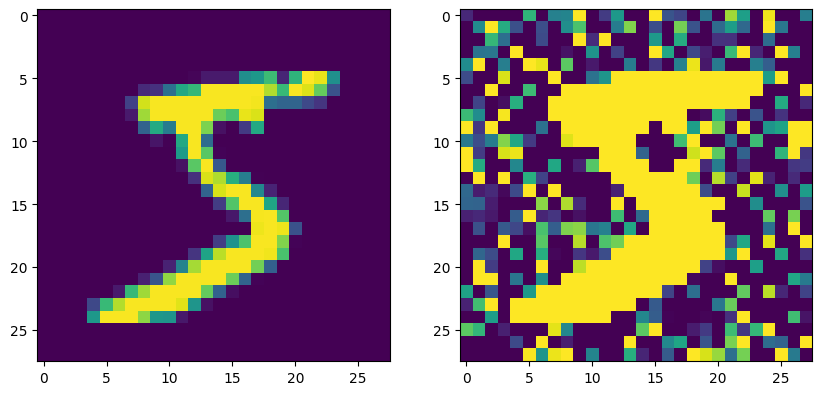

In [ ]:
# 데이터 가져오기
training_data = MNIST( root='./', train=True, download = True,transform = ToTensor())
test_data = MNIST( root='./', train=False, download = True,transform = ToTensor())
# 첫번째 원본이미지
origin_img = training_data.data[0]
noise_img = gaussian_noise(origin_img)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(origin_img)

plt.subplot(1,2,2)
plt.imshow(noise_img)

학습용데이터


In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor

class NoiseDataset(Dataset):
  def __init__(self):
    self.mnist = MNIST(root = './', train=True,download=True,transform=ToTensor())
    self.data = []  # 노이즈 섞인 데이터를 저장
    # 가우시안 노이즈 적용
    for data in self.mnist.data:
      self.data.append(gaussian_noise(data))
  def __len__(self):
    return len(self.data)
  def __getitem__(self, index):
    # torch.tensor(tensor)로 불필요한 차원 추가	tensor.float() 또는 tensor.clone().detach() 사용
    # return torch.tensor(self.data[index]).to(torch.float32), \
    #   torch.tensor(self.mnist.data[index] / 255.0).to(torch.float32)
    data = torch.tensor(self.data[index],dtype=torch.float32).unsqueeze(0)
    label = torch.tensor(self.mnist.data[index],dtype=torch.float32)
    return data, label

인코더 모델 정의
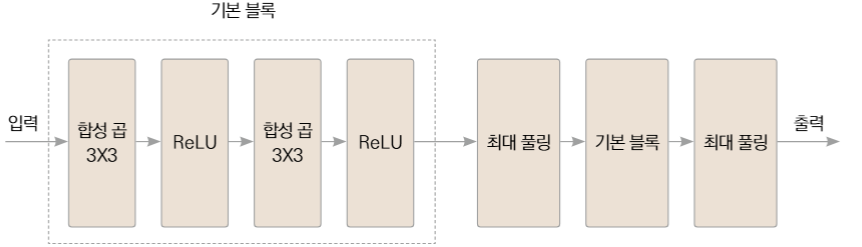

In [ ]:
import torch
import torch.nn as nn
class BasicBlock(nn.Module):
  def __init__(self, in_channels, out_channels, hidden_dim):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels, hidden_dim, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(hidden_dim, out_channels, kernel_size=3, padding=1)
    self.relu = nn.ReLU()
  def forward(self,x):
    x = self.relu(self.conv1(x))
    x = self.relu(self.conv2(x))
    return x

class Encoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.b1 = BasicBlock(in_channels=1, out_channels=16, hidden_dim=16)
    self.b2 = BasicBlock(in_channels=16, out_channels=8, hidden_dim=8)
    self.pool = nn.AvgPool2d(2,2)
  def forward(self,x):
    x = self.pool(self.b1(x))
    x = self.pool(self.b2(x))
    return x

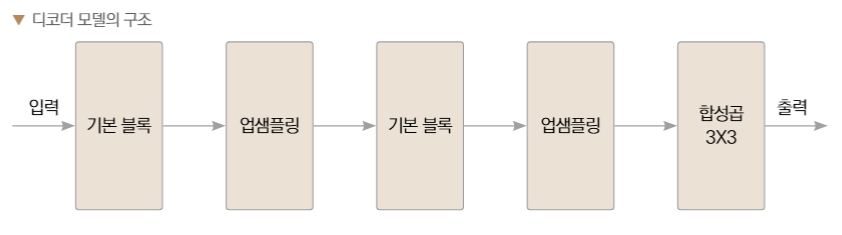

In [ ]:
class Decoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.b1 = BasicBlock(in_channels=8,out_channels=8,hidden_dim=8)
    self.b2 = BasicBlock(in_channels=8,out_channels=16,hidden_dim=16)
    self.conv1 = nn.Conv2d(in_channels=16,out_channels=1,kernel_size=3,padding=1)
    # 업셈플링층
    self.upsample1 = nn.ConvTranspose2d(in_channels=8,out_channels=8,kernel_size=2,stride=2)
    self.upsample2 = nn.ConvTranspose2d(in_channels=16,out_channels=16,kernel_size=2,stride=2)
  def forward(self,x):
    x = self.upsample1(self.b1(x))
    x = self.upsample2(self.b2(x))
    x = self.conv1(x)
    return x

CAE 모델 정의
```
인코더와 디코더를 결합
```

In [ ]:
class CAE(nn.Module):
  def __init__(self):
    super().__init__()
    self.enc = Encoder()
    self.dec = Decoder()
  def forward(self,x):
    x = self.enc(x)
    x = self.dec(x)
    return x

In [ ]:
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch
trainset = NoiseDataset()
train_loader = DataLoader(trainset,batch_size=32)
model = CAE()
lr = 1e-4
loss_fn = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(),lr=lr)
epochs = 200
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
for epoch in range(epochs):
  loss_all = 0.0
  iterator = tqdm(train_loader)
  for data, label in iterator:
    data,label = data.to(device), label.to(device)
    if data.shape[2] ==1:
      data = torch.unsqueeze(data,dim=2)
    predict = model(data)  # 예측
    loss = loss_fn(predict,label)
    loss.backward()
    optim.step()
    optim.zero_grad()
    loss_all += loss.item()
    iterator.set_description(f'epoch : {epoch+1}  ')
    iterator.set_postfix(loss=loss.item())
  if epoch % 50 ==0:
    torch.save(model.state_dict(),f'/content/drive/MyDrive/model/CAE_{epoch+1}.pth')

  print(f'epoch : {epoch+1} loss : {loss_all / len(train_loader.dataset)}')
torch.save(model.state_dict(),'/content/drive/MyDrive/model/CAE.pth')

<ipython-input-1-263b055d58b8>:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  gx = x + np.random.normal(loc=0,scale=scale,size=x.shape)  # 정규분포를 따르는 행렬을 만든다
  0%|          | 0/1875 [00:00<?, ?it/s]<ipython-input-3-5552ddb600d7>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(self.data[index],dtype=torch.float32).unsqueeze(0)
<ipython-input-3-5552ddb600d7>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(self.mnist.data[index],dtype=torch.float32)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (tor

epoch : 1 loss : 153.9967196492513


epoch : 2  : 100%|██████████| 1875/1875 [00:16<00:00, 112.55it/s, loss=4.18e+3]


epoch : 2 loss : 139.96446861979166


epoch : 3  : 100%|██████████| 1875/1875 [00:17<00:00, 109.62it/s, loss=4.19e+3]


epoch : 3 loss : 139.09784763997396


epoch : 4  : 100%|██████████| 1875/1875 [00:16<00:00, 117.17it/s, loss=4.19e+3]


epoch : 4 loss : 138.74052353922525


epoch : 5  : 100%|██████████| 1875/1875 [00:16<00:00, 116.68it/s, loss=4.19e+3]


epoch : 5 loss : 138.51268539632161


epoch : 6  : 100%|██████████| 1875/1875 [00:16<00:00, 116.07it/s, loss=4.18e+3]


epoch : 6 loss : 138.33171271158855


epoch : 7  : 100%|██████████| 1875/1875 [00:16<00:00, 116.86it/s, loss=4.18e+3]


epoch : 7 loss : 138.16084881184895


epoch : 8  : 100%|██████████| 1875/1875 [00:18<00:00, 99.45it/s, loss=4.18e+3]


epoch : 8 loss : 138.0225582763672


epoch : 9  : 100%|██████████| 1875/1875 [00:24<00:00, 76.37it/s, loss=4.18e+3] 


epoch : 9 loss : 137.88342844645183


epoch : 10  : 100%|██████████| 1875/1875 [00:16<00:00, 116.42it/s, loss=4.18e+3]


epoch : 10 loss : 137.75171056722004


epoch : 11  : 100%|██████████| 1875/1875 [00:16<00:00, 114.46it/s, loss=4.18e+3]


epoch : 11 loss : 137.6377939005534


epoch : 12  : 100%|██████████| 1875/1875 [00:16<00:00, 111.37it/s, loss=4.18e+3]


epoch : 12 loss : 137.54143795979817


epoch : 13  : 100%|██████████| 1875/1875 [00:16<00:00, 111.85it/s, loss=4.18e+3]


epoch : 13 loss : 137.45444210611979


epoch : 14  : 100%|██████████| 1875/1875 [00:16<00:00, 113.88it/s, loss=4.18e+3]


epoch : 14 loss : 137.38302576090496


epoch : 15  : 100%|██████████| 1875/1875 [00:17<00:00, 104.98it/s, loss=4.18e+3]


epoch : 15 loss : 137.3150186767578


epoch : 16  : 100%|██████████| 1875/1875 [00:16<00:00, 113.84it/s, loss=4.18e+3]


epoch : 16 loss : 137.25820294596355


epoch : 17  : 100%|██████████| 1875/1875 [00:16<00:00, 114.02it/s, loss=4.18e+3]


epoch : 17 loss : 137.20927963460286


epoch : 18  : 100%|██████████| 1875/1875 [00:16<00:00, 112.45it/s, loss=4.18e+3]


epoch : 18 loss : 137.16717283121744


epoch : 19  : 100%|██████████| 1875/1875 [00:16<00:00, 111.03it/s, loss=4.18e+3]


epoch : 19 loss : 137.13350757242839


epoch : 20  : 100%|██████████| 1875/1875 [00:16<00:00, 112.01it/s, loss=4.18e+3]


epoch : 20 loss : 137.10453893636068


epoch : 21  : 100%|██████████| 1875/1875 [00:16<00:00, 113.53it/s, loss=4.18e+3]


epoch : 21 loss : 137.077950382487


epoch : 22  : 100%|██████████| 1875/1875 [00:16<00:00, 112.60it/s, loss=4.18e+3]


epoch : 22 loss : 137.0523724527995


epoch : 23  : 100%|██████████| 1875/1875 [00:16<00:00, 114.85it/s, loss=4.18e+3]


epoch : 23 loss : 137.02911498209636


epoch : 24  : 100%|██████████| 1875/1875 [00:16<00:00, 111.87it/s, loss=4.18e+3]


epoch : 24 loss : 137.0075345987956


epoch : 25  : 100%|██████████| 1875/1875 [00:16<00:00, 111.47it/s, loss=4.18e+3]


epoch : 25 loss : 136.98633802897135


epoch : 26  : 100%|██████████| 1875/1875 [00:17<00:00, 108.51it/s, loss=4.18e+3]


epoch : 26 loss : 136.96502532145183


epoch : 27  : 100%|██████████| 1875/1875 [00:17<00:00, 110.09it/s, loss=4.18e+3]


epoch : 27 loss : 136.94519388020834


epoch : 28  : 100%|██████████| 1875/1875 [00:16<00:00, 111.56it/s, loss=4.18e+3]


epoch : 28 loss : 136.9277865600586


epoch : 29  : 100%|██████████| 1875/1875 [00:16<00:00, 111.92it/s, loss=4.18e+3]


epoch : 29 loss : 136.91164881591797


epoch : 30  : 100%|██████████| 1875/1875 [00:16<00:00, 111.83it/s, loss=4.18e+3]


epoch : 30 loss : 136.89674865315754


epoch : 31  : 100%|██████████| 1875/1875 [00:16<00:00, 112.70it/s, loss=4.19e+3]


epoch : 31 loss : 136.8802732462565


epoch : 32  : 100%|██████████| 1875/1875 [00:16<00:00, 112.48it/s, loss=4.19e+3]


epoch : 32 loss : 136.86446044921874


epoch : 33  : 100%|██████████| 1875/1875 [00:16<00:00, 111.22it/s, loss=4.19e+3]


epoch : 33 loss : 136.85149628092447


epoch : 34  : 100%|██████████| 1875/1875 [00:16<00:00, 111.54it/s, loss=4.19e+3]


epoch : 34 loss : 136.84001153564452


epoch : 35  : 100%|██████████| 1875/1875 [00:17<00:00, 109.91it/s, loss=4.19e+3]


epoch : 35 loss : 136.82955307210287


epoch : 36  : 100%|██████████| 1875/1875 [00:16<00:00, 110.46it/s, loss=4.19e+3]


epoch : 36 loss : 136.81971063639324


epoch : 37  : 100%|██████████| 1875/1875 [00:16<00:00, 113.23it/s, loss=4.2e+3]


epoch : 37 loss : 136.81047944742838


epoch : 38  : 100%|██████████| 1875/1875 [00:16<00:00, 112.29it/s, loss=4.2e+3]


epoch : 38 loss : 136.80135260416668


epoch : 39  : 100%|██████████| 1875/1875 [00:16<00:00, 111.85it/s, loss=4.2e+3]


epoch : 39 loss : 136.7927683186849


epoch : 40  : 100%|██████████| 1875/1875 [00:16<00:00, 111.46it/s, loss=4.2e+3]


epoch : 40 loss : 136.78428360595703


epoch : 41  : 100%|██████████| 1875/1875 [00:16<00:00, 111.92it/s, loss=4.2e+3]


epoch : 41 loss : 136.77519370117187


epoch : 42  : 100%|██████████| 1875/1875 [00:18<00:00, 101.36it/s, loss=4.21e+3]


epoch : 42 loss : 136.76604725748697


epoch : 43  : 100%|██████████| 1875/1875 [00:17<00:00, 110.28it/s, loss=4.21e+3]


epoch : 43 loss : 136.75861073811848


epoch : 44  : 100%|██████████| 1875/1875 [00:17<00:00, 108.93it/s, loss=4.21e+3]


epoch : 44 loss : 136.7520670369466


epoch : 45  : 100%|██████████| 1875/1875 [00:17<00:00, 109.44it/s, loss=4.21e+3]


epoch : 45 loss : 136.74582252197266


epoch : 46  : 100%|██████████| 1875/1875 [00:16<00:00, 111.48it/s, loss=4.21e+3]


epoch : 46 loss : 136.73933173421224


epoch : 47  : 100%|██████████| 1875/1875 [00:16<00:00, 110.40it/s, loss=4.21e+3]


epoch : 47 loss : 136.73363471272788


epoch : 48  : 100%|██████████| 1875/1875 [00:16<00:00, 112.71it/s, loss=4.22e+3]


epoch : 48 loss : 136.72801043701173


epoch : 49  : 100%|██████████| 1875/1875 [00:16<00:00, 112.00it/s, loss=4.22e+3]


epoch : 49 loss : 136.72282170817058


epoch : 50  : 100%|██████████| 1875/1875 [00:16<00:00, 112.44it/s, loss=4.22e+3]


epoch : 50 loss : 136.71795321451822


epoch : 51  : 100%|██████████| 1875/1875 [00:16<00:00, 111.44it/s, loss=4.22e+3]


epoch : 51 loss : 136.71322395833334


epoch : 52  : 100%|██████████| 1875/1875 [00:16<00:00, 110.75it/s, loss=4.22e+3]


epoch : 52 loss : 136.7087119099935


epoch : 53  : 100%|██████████| 1875/1875 [00:17<00:00, 108.38it/s, loss=4.22e+3]


epoch : 53 loss : 136.70461050211588


epoch : 54  : 100%|██████████| 1875/1875 [00:17<00:00, 109.21it/s, loss=4.22e+3]


epoch : 54 loss : 136.70046427408855


epoch : 55  : 100%|██████████| 1875/1875 [00:17<00:00, 109.73it/s, loss=4.22e+3]


epoch : 55 loss : 136.696578125


epoch : 56  : 100%|██████████| 1875/1875 [00:17<00:00, 105.84it/s, loss=4.22e+3]


epoch : 56 loss : 136.69296213378905


epoch : 57  : 100%|██████████| 1875/1875 [00:17<00:00, 108.73it/s, loss=4.23e+3]


epoch : 57 loss : 136.6894034749349


epoch : 58  : 100%|██████████| 1875/1875 [00:17<00:00, 108.32it/s, loss=4.23e+3]


epoch : 58 loss : 136.68608903808592


epoch : 59  : 100%|██████████| 1875/1875 [00:17<00:00, 108.68it/s, loss=4.23e+3]


epoch : 59 loss : 136.68291204833983


epoch : 60  : 100%|██████████| 1875/1875 [00:17<00:00, 108.66it/s, loss=4.23e+3]


epoch : 60 loss : 136.67985040690104


epoch : 61  : 100%|██████████| 1875/1875 [00:17<00:00, 109.57it/s, loss=4.23e+3]


epoch : 61 loss : 136.67690021158853


epoch : 62  : 100%|██████████| 1875/1875 [00:17<00:00, 109.82it/s, loss=4.23e+3]


epoch : 62 loss : 136.67425221354168


epoch : 63  : 100%|██████████| 1875/1875 [00:17<00:00, 107.48it/s, loss=4.23e+3]


epoch : 63 loss : 136.6715536336263


epoch : 64  : 100%|██████████| 1875/1875 [00:17<00:00, 107.47it/s, loss=4.23e+3]


epoch : 64 loss : 136.6689532836914


epoch : 65  : 100%|██████████| 1875/1875 [00:17<00:00, 105.62it/s, loss=4.24e+3]


epoch : 65 loss : 136.6665398071289


epoch : 66  : 100%|██████████| 1875/1875 [00:17<00:00, 106.01it/s, loss=4.24e+3]


epoch : 66 loss : 136.66418275553386


epoch : 67  : 100%|██████████| 1875/1875 [00:17<00:00, 107.37it/s, loss=4.24e+3]


epoch : 67 loss : 136.66180205891928


epoch : 68  : 100%|██████████| 1875/1875 [00:17<00:00, 107.61it/s, loss=4.24e+3]


epoch : 68 loss : 136.6593766723633


epoch : 69  : 100%|██████████| 1875/1875 [00:17<00:00, 107.84it/s, loss=4.24e+3]


epoch : 69 loss : 136.65690416259767


epoch : 70  : 100%|██████████| 1875/1875 [00:17<00:00, 109.15it/s, loss=4.24e+3]


epoch : 70 loss : 136.6544833211263


epoch : 71  : 100%|██████████| 1875/1875 [00:17<00:00, 108.44it/s, loss=4.24e+3]


epoch : 71 loss : 136.65231190185546


epoch : 72  : 100%|██████████| 1875/1875 [00:17<00:00, 108.26it/s, loss=4.24e+3]


epoch : 72 loss : 136.65006788330078


epoch : 73  : 100%|██████████| 1875/1875 [00:17<00:00, 108.69it/s, loss=4.24e+3]


epoch : 73 loss : 136.64789564208985


epoch : 74  : 100%|██████████| 1875/1875 [00:17<00:00, 107.91it/s, loss=4.25e+3]


epoch : 74 loss : 136.64584403483073


epoch : 75  : 100%|██████████| 1875/1875 [00:17<00:00, 109.02it/s, loss=4.25e+3]


epoch : 75 loss : 136.6438127400716


epoch : 76  : 100%|██████████| 1875/1875 [00:17<00:00, 108.28it/s, loss=4.25e+3]


epoch : 76 loss : 136.6417734375


epoch : 77  : 100%|██████████| 1875/1875 [00:17<00:00, 106.92it/s, loss=4.25e+3]


epoch : 77 loss : 136.63982599283855


epoch : 78  : 100%|██████████| 1875/1875 [00:17<00:00, 107.62it/s, loss=4.25e+3]


epoch : 78 loss : 136.63795969645182


epoch : 79  : 100%|██████████| 1875/1875 [00:17<00:00, 105.89it/s, loss=4.25e+3]


epoch : 79 loss : 136.6361906982422


epoch : 80  : 100%|██████████| 1875/1875 [00:17<00:00, 104.41it/s, loss=4.25e+3]


epoch : 80 loss : 136.6344362141927


epoch : 81  : 100%|██████████| 1875/1875 [00:17<00:00, 105.19it/s, loss=4.25e+3]


epoch : 81 loss : 136.63265260823567


epoch : 82  : 100%|██████████| 1875/1875 [00:17<00:00, 105.98it/s, loss=4.25e+3]


epoch : 82 loss : 136.63087869873047


epoch : 83  : 100%|██████████| 1875/1875 [00:17<00:00, 106.05it/s, loss=4.26e+3]


epoch : 83 loss : 136.6290807820638


epoch : 84  : 100%|██████████| 1875/1875 [00:17<00:00, 105.80it/s, loss=4.26e+3]


epoch : 84 loss : 136.62726169026692


epoch : 85  : 100%|██████████| 1875/1875 [00:17<00:00, 106.56it/s, loss=4.26e+3]


epoch : 85 loss : 136.62545463053385


epoch : 86  : 100%|██████████| 1875/1875 [00:17<00:00, 105.89it/s, loss=4.26e+3]


epoch : 86 loss : 136.62362072753905


epoch : 87  : 100%|██████████| 1875/1875 [00:17<00:00, 106.26it/s, loss=4.26e+3]


epoch : 87 loss : 136.6218232788086


epoch : 88  : 100%|██████████| 1875/1875 [00:17<00:00, 106.41it/s, loss=4.26e+3]


epoch : 88 loss : 136.6199967569987


epoch : 89  : 100%|██████████| 1875/1875 [00:17<00:00, 106.25it/s, loss=4.26e+3]


epoch : 89 loss : 136.61826271565755


epoch : 90  : 100%|██████████| 1875/1875 [00:17<00:00, 105.39it/s, loss=4.26e+3]


epoch : 90 loss : 136.6165386271159


epoch : 91  : 100%|██████████| 1875/1875 [00:17<00:00, 105.55it/s, loss=4.26e+3]


epoch : 91 loss : 136.61491846110027


epoch : 92  : 100%|██████████| 1875/1875 [00:17<00:00, 105.19it/s, loss=4.26e+3]


epoch : 92 loss : 136.61307416992187


epoch : 93  : 100%|██████████| 1875/1875 [00:17<00:00, 105.64it/s, loss=4.26e+3]


epoch : 93 loss : 136.61139971516928


epoch : 94  : 100%|██████████| 1875/1875 [00:18<00:00, 103.41it/s, loss=4.26e+3]


epoch : 94 loss : 136.60977219645181


epoch : 95  : 100%|██████████| 1875/1875 [00:18<00:00, 103.05it/s, loss=4.26e+3]


epoch : 95 loss : 136.60818581136067


epoch : 96  : 100%|██████████| 1875/1875 [00:17<00:00, 104.17it/s, loss=4.27e+3]


epoch : 96 loss : 136.60664979248048


epoch : 97  : 100%|██████████| 1875/1875 [00:17<00:00, 104.94it/s, loss=4.27e+3]


epoch : 97 loss : 136.60504940999348


epoch : 98  : 100%|██████████| 1875/1875 [00:18<00:00, 104.03it/s, loss=4.27e+3]


epoch : 98 loss : 136.6034814860026


epoch : 99  : 100%|██████████| 1875/1875 [00:18<00:00, 103.76it/s, loss=4.27e+3]


epoch : 99 loss : 136.60203138020833


epoch : 100  : 100%|██████████| 1875/1875 [00:17<00:00, 104.55it/s, loss=4.27e+3]


epoch : 100 loss : 136.60040275065103


epoch : 101  : 100%|██████████| 1875/1875 [00:18<00:00, 103.93it/s, loss=4.27e+3]


epoch : 101 loss : 136.59871525472005


epoch : 102  : 100%|██████████| 1875/1875 [00:17<00:00, 104.54it/s, loss=4.27e+3]


epoch : 102 loss : 136.59703048095705


epoch : 103  : 100%|██████████| 1875/1875 [00:17<00:00, 104.53it/s, loss=4.27e+3]


epoch : 103 loss : 136.59529417317708


epoch : 104  : 100%|██████████| 1875/1875 [00:18<00:00, 103.92it/s, loss=4.27e+3]


epoch : 104 loss : 136.5936052652995


epoch : 105  : 100%|██████████| 1875/1875 [00:18<00:00, 102.99it/s, loss=4.27e+3]


epoch : 105 loss : 136.5919186686198


epoch : 106  : 100%|██████████| 1875/1875 [00:18<00:00, 103.86it/s, loss=4.27e+3]


epoch : 106 loss : 136.59025233561198


epoch : 107  : 100%|██████████| 1875/1875 [00:18<00:00, 104.08it/s, loss=4.27e+3]


epoch : 107 loss : 136.58845076497397


epoch : 108  : 100%|██████████| 1875/1875 [00:18<00:00, 103.51it/s, loss=4.27e+3]


epoch : 108 loss : 136.58679498291016


epoch : 109  : 100%|██████████| 1875/1875 [00:18<00:00, 103.97it/s, loss=4.27e+3]


epoch : 109 loss : 136.58515545247397


epoch : 110  : 100%|██████████| 1875/1875 [00:18<00:00, 103.78it/s, loss=4.27e+3]


epoch : 110 loss : 136.5834887084961


epoch : 111  : 100%|██████████| 1875/1875 [00:17<00:00, 104.35it/s, loss=4.27e+3]


epoch : 111 loss : 136.5818505004883


epoch : 112  : 100%|██████████| 1875/1875 [00:18<00:00, 102.89it/s, loss=4.27e+3]


epoch : 112 loss : 136.58025667317708


epoch : 113  : 100%|██████████| 1875/1875 [00:18<00:00, 102.88it/s, loss=4.27e+3]


epoch : 113 loss : 136.57863721110027


epoch : 114  : 100%|██████████| 1875/1875 [00:18<00:00, 101.68it/s, loss=4.27e+3]


epoch : 114 loss : 136.5771086710612


epoch : 115  : 100%|██████████| 1875/1875 [00:18<00:00, 101.60it/s, loss=4.27e+3]


epoch : 115 loss : 136.57563333333334


epoch : 116  : 100%|██████████| 1875/1875 [00:18<00:00, 103.49it/s, loss=4.28e+3]


epoch : 116 loss : 136.57414604899088


epoch : 117  : 100%|██████████| 1875/1875 [00:18<00:00, 101.21it/s, loss=4.28e+3]


epoch : 117 loss : 136.57262931315105


epoch : 118  : 100%|██████████| 1875/1875 [00:18<00:00, 102.80it/s, loss=4.28e+3]


epoch : 118 loss : 136.5711332763672


epoch : 119  : 100%|██████████| 1875/1875 [00:18<00:00, 102.82it/s, loss=4.28e+3]


epoch : 119 loss : 136.5696735961914


epoch : 120  : 100%|██████████| 1875/1875 [00:18<00:00, 104.04it/s, loss=4.28e+3]


epoch : 120 loss : 136.56819537760416


epoch : 121  : 100%|██████████| 1875/1875 [00:18<00:00, 102.26it/s, loss=4.28e+3]


epoch : 121 loss : 136.56678966878255


epoch : 122  : 100%|██████████| 1875/1875 [00:18<00:00, 102.29it/s, loss=4.28e+3]


epoch : 122 loss : 136.5653894083659


epoch : 123  : 100%|██████████| 1875/1875 [00:18<00:00, 102.56it/s, loss=4.28e+3]


epoch : 123 loss : 136.56396889241537


epoch : 124  : 100%|██████████| 1875/1875 [00:18<00:00, 102.81it/s, loss=4.28e+3]


epoch : 124 loss : 136.5625239827474


epoch : 125  : 100%|██████████| 1875/1875 [00:18<00:00, 102.81it/s, loss=4.28e+3]


epoch : 125 loss : 136.56111546223957


epoch : 126  : 100%|██████████| 1875/1875 [00:18<00:00, 102.42it/s, loss=4.28e+3]


epoch : 126 loss : 136.55968372802735


epoch : 127  : 100%|██████████| 1875/1875 [00:18<00:00, 101.44it/s, loss=4.28e+3]


epoch : 127 loss : 136.55833038330078


epoch : 128  : 100%|██████████| 1875/1875 [00:18<00:00, 103.69it/s, loss=4.28e+3]


epoch : 128 loss : 136.55693829752605


epoch : 129  : 100%|██████████| 1875/1875 [00:18<00:00, 103.51it/s, loss=4.28e+3]


epoch : 129 loss : 136.55561618245443


epoch : 130  : 100%|██████████| 1875/1875 [00:18<00:00, 100.60it/s, loss=4.28e+3]


epoch : 130 loss : 136.55418191731772


epoch : 131  : 100%|██████████| 1875/1875 [00:18<00:00, 102.47it/s, loss=4.28e+3]


epoch : 131 loss : 136.55287639567058


epoch : 132  : 100%|██████████| 1875/1875 [00:18<00:00, 101.27it/s, loss=4.28e+3]


epoch : 132 loss : 136.5515400065104


epoch : 133  : 100%|██████████| 1875/1875 [00:18<00:00, 101.76it/s, loss=4.28e+3]


epoch : 133 loss : 136.55017864176432


epoch : 134  : 100%|██████████| 1875/1875 [00:18<00:00, 100.13it/s, loss=4.28e+3]


epoch : 134 loss : 136.5487918660482


epoch : 135  : 100%|██████████| 1875/1875 [00:18<00:00, 102.03it/s, loss=4.28e+3]


epoch : 135 loss : 136.5473990559896


epoch : 136  : 100%|██████████| 1875/1875 [00:18<00:00, 101.72it/s, loss=4.28e+3]


epoch : 136 loss : 136.54600577392577


epoch : 137  : 100%|██████████| 1875/1875 [00:18<00:00, 103.92it/s, loss=4.28e+3]


epoch : 137 loss : 136.54466544596355


epoch : 138  : 100%|██████████| 1875/1875 [00:18<00:00, 101.07it/s, loss=4.28e+3]


epoch : 138 loss : 136.543335160319


epoch : 139  : 100%|██████████| 1875/1875 [00:19<00:00, 98.52it/s, loss=4.28e+3] 


epoch : 139 loss : 136.5419668782552


epoch : 140  : 100%|██████████| 1875/1875 [00:19<00:00, 96.91it/s, loss=4.28e+3]


epoch : 140 loss : 136.54063709716797


epoch : 141  : 100%|██████████| 1875/1875 [00:18<00:00, 99.79it/s, loss=4.28e+3] 


epoch : 141 loss : 136.53919193522137


epoch : 142  : 100%|██████████| 1875/1875 [00:19<00:00, 96.74it/s, loss=4.28e+3] 


epoch : 142 loss : 136.53785635986327


epoch : 143  : 100%|██████████| 1875/1875 [00:18<00:00, 100.54it/s, loss=4.28e+3]


epoch : 143 loss : 136.5365995686849


epoch : 144  : 100%|██████████| 1875/1875 [00:19<00:00, 98.51it/s, loss=4.28e+3]


epoch : 144 loss : 136.53534714355467


epoch : 145  : 100%|██████████| 1875/1875 [00:19<00:00, 96.27it/s, loss=4.28e+3]


epoch : 145 loss : 136.53407654215493


epoch : 146  : 100%|██████████| 1875/1875 [00:19<00:00, 98.33it/s, loss=4.28e+3] 


epoch : 146 loss : 136.53288254801433


epoch : 147  : 100%|██████████| 1875/1875 [00:19<00:00, 98.18it/s, loss=4.28e+3]


epoch : 147 loss : 136.53163185628256


epoch : 148  : 100%|██████████| 1875/1875 [00:19<00:00, 98.18it/s, loss=4.28e+3]


epoch : 148 loss : 136.53041288655598


epoch : 149  : 100%|██████████| 1875/1875 [00:19<00:00, 97.87it/s, loss=4.28e+3] 


epoch : 149 loss : 136.52919368082684


epoch : 150  : 100%|██████████| 1875/1875 [00:19<00:00, 97.56it/s, loss=4.28e+3] 


epoch : 150 loss : 136.52778992106118


epoch : 151  : 100%|██████████| 1875/1875 [00:19<00:00, 98.34it/s, loss=4.28e+3] 


epoch : 151 loss : 136.52650420328777


epoch : 152  : 100%|██████████| 1875/1875 [00:19<00:00, 95.18it/s, loss=4.28e+3]


epoch : 152 loss : 136.52531391194663


epoch : 153  : 100%|██████████| 1875/1875 [00:19<00:00, 95.88it/s, loss=4278.75]


epoch : 153 loss : 136.52414134521484


epoch : 154  : 100%|██████████| 1875/1875 [00:18<00:00, 99.12it/s, loss=4.28e+3] 


epoch : 154 loss : 136.52303818359374


epoch : 155  : 100%|██████████| 1875/1875 [00:19<00:00, 97.32it/s, loss=4.28e+3] 


epoch : 155 loss : 136.52191501871744


epoch : 156  : 100%|██████████| 1875/1875 [00:19<00:00, 96.96it/s, loss=4.28e+3]


epoch : 156 loss : 136.52070319010417


epoch : 157  : 100%|██████████| 1875/1875 [00:19<00:00, 96.43it/s, loss=4.28e+3] 


epoch : 157 loss : 136.51960381673177


epoch : 158  : 100%|██████████| 1875/1875 [00:19<00:00, 97.94it/s, loss=4.28e+3]


epoch : 158 loss : 136.51853919677734


epoch : 159  : 100%|██████████| 1875/1875 [00:19<00:00, 96.44it/s, loss=4.28e+3]


epoch : 159 loss : 136.51743748779296


epoch : 160  : 100%|██████████| 1875/1875 [00:18<00:00, 99.34it/s, loss=4.28e+3]


epoch : 160 loss : 136.5163170654297


epoch : 161  : 100%|██████████| 1875/1875 [00:18<00:00, 98.81it/s, loss=4.28e+3] 


epoch : 161 loss : 136.51528470052082


epoch : 162  : 100%|██████████| 1875/1875 [00:19<00:00, 97.81it/s, loss=4.28e+3] 


epoch : 162 loss : 136.5139489908854


epoch : 163  : 100%|██████████| 1875/1875 [00:19<00:00, 96.97it/s, loss=4.28e+3]


epoch : 163 loss : 136.5131455810547


epoch : 164  : 100%|██████████| 1875/1875 [00:19<00:00, 96.84it/s, loss=4.28e+3]


epoch : 164 loss : 136.51235750732423


epoch : 165  : 100%|██████████| 1875/1875 [00:19<00:00, 96.15it/s, loss=4.28e+3]


epoch : 165 loss : 136.5114557006836


epoch : 166  : 100%|██████████| 1875/1875 [00:19<00:00, 97.54it/s, loss=4.28e+3] 


epoch : 166 loss : 136.51038240152994


epoch : 167  : 100%|██████████| 1875/1875 [00:19<00:00, 97.89it/s, loss=4.28e+3]


epoch : 167 loss : 136.50952166748047


epoch : 168  : 100%|██████████| 1875/1875 [00:19<00:00, 96.91it/s, loss=4.28e+3]


epoch : 168 loss : 136.50857463785806


epoch : 169  : 100%|██████████| 1875/1875 [00:19<00:00, 98.19it/s, loss=4.28e+3]


epoch : 169 loss : 136.50768268636068


epoch : 170  : 100%|██████████| 1875/1875 [00:19<00:00, 96.59it/s, loss=4.28e+3]


epoch : 170 loss : 136.50685417073566


epoch : 171  : 100%|██████████| 1875/1875 [00:19<00:00, 98.52it/s, loss=4.28e+3]


epoch : 171 loss : 136.50598790690105


epoch : 172  : 100%|██████████| 1875/1875 [00:19<00:00, 98.49it/s, loss=4.28e+3]


epoch : 172 loss : 136.50514036865235


epoch : 173  : 100%|██████████| 1875/1875 [00:18<00:00, 100.34it/s, loss=4.28e+3]


epoch : 173 loss : 136.50422811686198


epoch : 174  : 100%|██████████| 1875/1875 [00:19<00:00, 96.83it/s, loss=4.28e+3] 


epoch : 174 loss : 136.5033893798828


epoch : 175  : 100%|██████████| 1875/1875 [00:19<00:00, 97.50it/s, loss=4.28e+3]


epoch : 175 loss : 136.5024692626953


epoch : 176  : 100%|██████████| 1875/1875 [00:19<00:00, 96.65it/s, loss=4.28e+3]


epoch : 176 loss : 136.50161758626302


epoch : 177  : 100%|██████████| 1875/1875 [00:19<00:00, 97.57it/s, loss=4.28e+3]


epoch : 177 loss : 136.5008185913086


epoch : 178  : 100%|██████████| 1875/1875 [00:19<00:00, 98.02it/s, loss=4.28e+3]


epoch : 178 loss : 136.49994357503255


epoch : 179  : 100%|██████████| 1875/1875 [00:18<00:00, 100.44it/s, loss=4.28e+3]


epoch : 179 loss : 136.49913127848308


epoch : 180  : 100%|██████████| 1875/1875 [00:19<00:00, 98.23it/s, loss=4.28e+3] 


epoch : 180 loss : 136.49825505371095


epoch : 181  : 100%|██████████| 1875/1875 [00:19<00:00, 96.27it/s, loss=4.28e+3]


epoch : 181 loss : 136.49734159342447


epoch : 182  : 100%|██████████| 1875/1875 [00:18<00:00, 99.35it/s, loss=4.28e+3]


epoch : 182 loss : 136.49653642578124


epoch : 183  : 100%|██████████| 1875/1875 [00:19<00:00, 97.41it/s, loss=4.28e+3]


epoch : 183 loss : 136.49568021240233


epoch : 184  : 100%|██████████| 1875/1875 [00:18<00:00, 100.27it/s, loss=4.28e+3]


epoch : 184 loss : 136.4948422607422


epoch : 185  : 100%|██████████| 1875/1875 [00:19<00:00, 98.63it/s, loss=4.28e+3]


epoch : 185 loss : 136.4939502726237


epoch : 186  : 100%|██████████| 1875/1875 [00:19<00:00, 96.31it/s, loss=4.28e+3]


epoch : 186 loss : 136.49312551269531


epoch : 187  : 100%|██████████| 1875/1875 [00:19<00:00, 96.20it/s, loss=4.28e+3]


epoch : 187 loss : 136.49228349609376


epoch : 188  : 100%|██████████| 1875/1875 [00:19<00:00, 97.18it/s, loss=4.28e+3] 


epoch : 188 loss : 136.49131411132814


epoch : 189  : 100%|██████████| 1875/1875 [00:18<00:00, 98.82it/s, loss=4.28e+3]


epoch : 189 loss : 136.49045046386718


epoch : 190  : 100%|██████████| 1875/1875 [00:19<00:00, 97.52it/s, loss=4.28e+3]


epoch : 190 loss : 136.48955326334635


epoch : 191  : 100%|██████████| 1875/1875 [00:18<00:00, 98.82it/s, loss=4.28e+3] 


epoch : 191 loss : 136.4887515258789


epoch : 192  : 100%|██████████| 1875/1875 [00:19<00:00, 96.05it/s, loss=4.28e+3]


epoch : 192 loss : 136.48793122965495


epoch : 193  : 100%|██████████| 1875/1875 [00:19<00:00, 98.19it/s, loss=4.28e+3]


epoch : 193 loss : 136.4871362508138


epoch : 194  : 100%|██████████| 1875/1875 [00:19<00:00, 97.15it/s, loss=4.28e+3]


epoch : 194 loss : 136.48643009033202


epoch : 195  : 100%|██████████| 1875/1875 [00:19<00:00, 96.62it/s, loss=4.28e+3]


epoch : 195 loss : 136.48560246988933


epoch : 196  : 100%|██████████| 1875/1875 [00:19<00:00, 98.10it/s, loss=4.28e+3] 


epoch : 196 loss : 136.4848619466146


epoch : 197  : 100%|██████████| 1875/1875 [00:19<00:00, 97.47it/s, loss=4.28e+3]


epoch : 197 loss : 136.4840818359375


epoch : 198  : 100%|██████████| 1875/1875 [00:19<00:00, 96.17it/s, loss=4.28e+3]


epoch : 198 loss : 136.48328829752603


epoch : 199  : 100%|██████████| 1875/1875 [00:19<00:00, 94.52it/s, loss=4.28e+3] 


epoch : 199 loss : 136.48256208902995


epoch : 200  : 100%|██████████| 1875/1875 [00:19<00:00, 97.42it/s, loss=4.28e+3]


epoch : 200 loss : 136.48174996337892


저장된 모델 불러오기

In [ ]:
loaded_model = CAE()
loaded_model.load_state_dict(torch.load('/content/drive/MyDrive/model/CAE.pth'))

<All keys matched successfully>

7
torch.Size([1, 28, 28])


<ipython-input-1-263b055d58b8>:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  gx = x + np.random.normal(loc=0,scale=scale,size=x.shape)  # 정규분포를 따르는 행렬을 만든다
<ipython-input-9-befb96daee05>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian = torch.tensor(gaussian_noise(img),dtype=torch.float32)


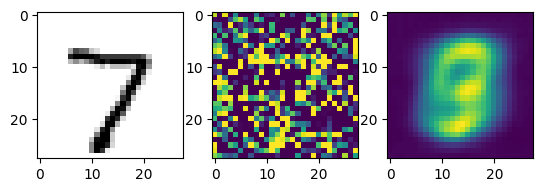

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
loaded_model = loaded_model.to(device)
with torch.no_grad():
  img,label = next(iter(test_data))
  print(label)
  gaussian = torch.tensor(gaussian_noise(img),dtype=torch.float32)
  gaussian = torch.unsqueeze(gaussian,dim=0)  # (1,1,32,32)
  gaussian = gaussian.to(device)
  predict = loaded_model(gaussian)
  print(predict[0].shape)
  plt.subplot(1,3,1)  #원본
  plt.imshow(img[0],cmap='gray_r')
  plt.subplot(1,3,2)  # 노이즈
  plt.imshow(gaussian[0][0].cpu().detach().numpy())  # plt는 gpu와 호환되지 않아서 cpu로 이동해서 출력
  plt.subplot(1,3,3)  # 예측
  plt.imshow(predict[0][0].cpu().detach().numpy()) # plt는 gpu와 호환되지 않아서 cpu로 이동해서 출력